In [1]:
import numpy as np
import torch

import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import seaborn

from pfhedge.nn import Hedger, BlackScholes, MultiLayerPerceptron, \
    ExpectedShortfall, Clamp, WhalleyWilmott
from pfhedge.instruments import BrownianStock, EuropeanOption, MertonJumpStock

import torch.nn.functional as fn
from torch import Tensor
from torch.nn import Module

In [2]:
seaborn.set_style("whitegrid")

FONTSIZE = 18
matplotlib.rcParams["figure.figsize"] = (10, 5)
matplotlib.rcParams["figure.dpi"] = 300
matplotlib.rcParams["figure.titlesize"] = FONTSIZE
matplotlib.rcParams["font.family"] = "sans-serif"
matplotlib.rcParams["legend.fontsize"] = FONTSIZE
matplotlib.rcParams["xtick.labelsize"] = FONTSIZE
matplotlib.rcParams["ytick.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.titlesize"] = FONTSIZE
matplotlib.rcParams["savefig.bbox"] = "tight"
matplotlib.rcParams["savefig.pad_inches"] = 0.1
matplotlib.rcParams["lines.linewidth"] = 2
matplotlib.rcParams["axes.linewidth"] = 1.6

In [3]:
torch.manual_seed(42)

if not torch.cuda.is_available():
    raise RuntimeWarning(
        "CUDA is not available. "
        "If you're using Google Colab, you can enable GPUs as: "
        "https://colab.research.google.com/notebooks/gpu.ipynb"
    )

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Default device:", DEVICE)

Default device: cuda:0


In [4]:
# In each epoch, N_PATHS brownian motion time-series are generated.
N_PATHS = 50000
# How many times a model is updated in the experiment.
N_EPOCHS = 200

In [5]:
def to_numpy(tensor: torch.Tensor) -> np.array:
    return tensor.cpu().detach().numpy()

# How to Use

## Prepare Instruments

We consider a `BrownianStock`, which is a stock following the geometric Brownian motion, and a `EuropeanOption` which is contingent on it.

We assume that the stock has a transaction cost given by `cost`.

In [31]:
stock = BrownianStock(cost=1e-3, device=DEVICE)
derivative = EuropeanOption(stock)

## Create Your Hedger

In [ ]:
model_mlp = MultiLayerPerceptron()
hedger_mlp = Hedger(
    model_mlp, inputs=["log_moneyness", "expiry_time", "volatility", "prev_hedge"]
).to(DEVICE)

The `hedger` is also a [`Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module).

In [10]:
history_mlp = hedger_mlp.fit(derivative, n_epochs=N_EPOCHS, n_paths=N_PATHS, n_times=20)

Loss=0.0230: 100%|██████████| 200/200 [02:43<00:00,  1.23it/s]


In [37]:
def plot_history(history, title):
    plt.plot(history)
    plt.xlabel("Number of epochs")
    plt.ylabel("Loss")
    plt.title(title)
    plt.show()

In [7]:
def get_pnl(hedger, derivative, n_paths):
    pnl = hedger.compute_pnl(derivative, n_paths=n_paths)
    return to_numpy(pnl)

In [8]:
def plot_pnl(hedger, derivative, n_paths, title):
    pnl = hedger.compute_pnl(derivative, n_paths=n_paths)
    plt.figure()
    plt.hist(to_numpy(pnl), bins=200)
    plt.title(title)
    plt.xlabel("Profit-loss")
    plt.ylabel("Number of events")
    plt.show()

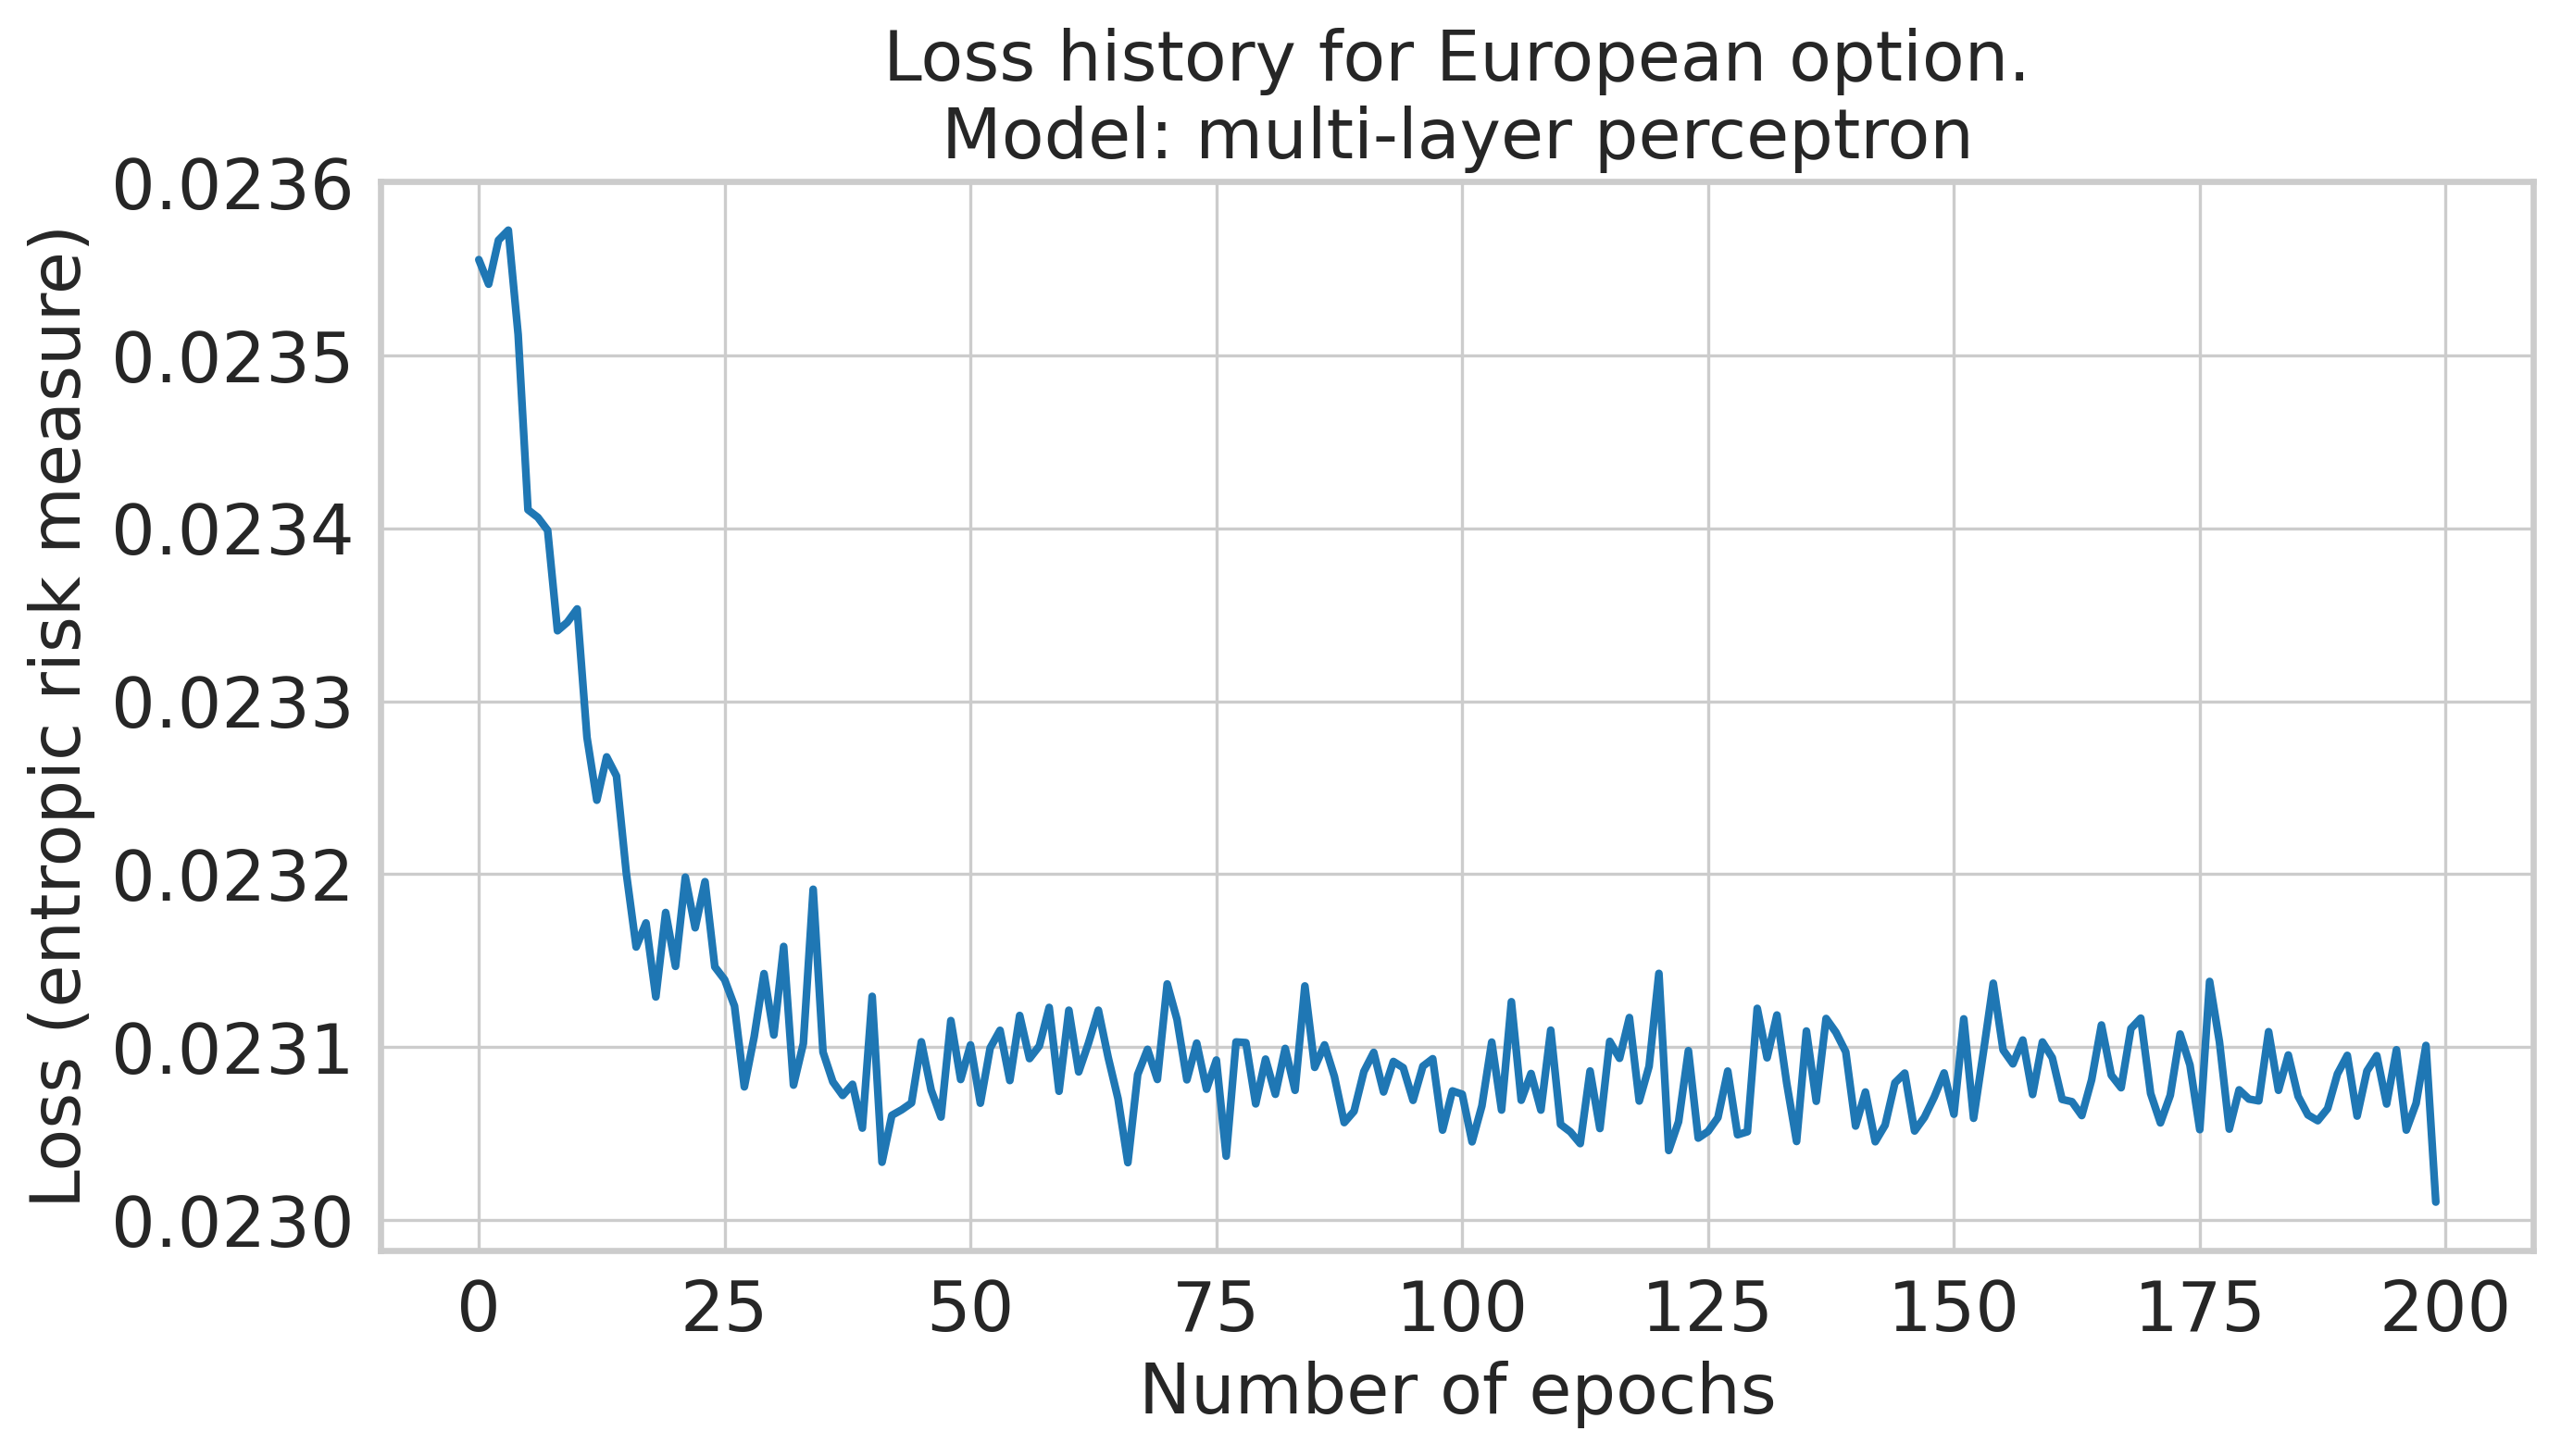

In [55]:
plot_history(history_mlp, "Loss history for European option.\nModel: multi-layer perceptron")

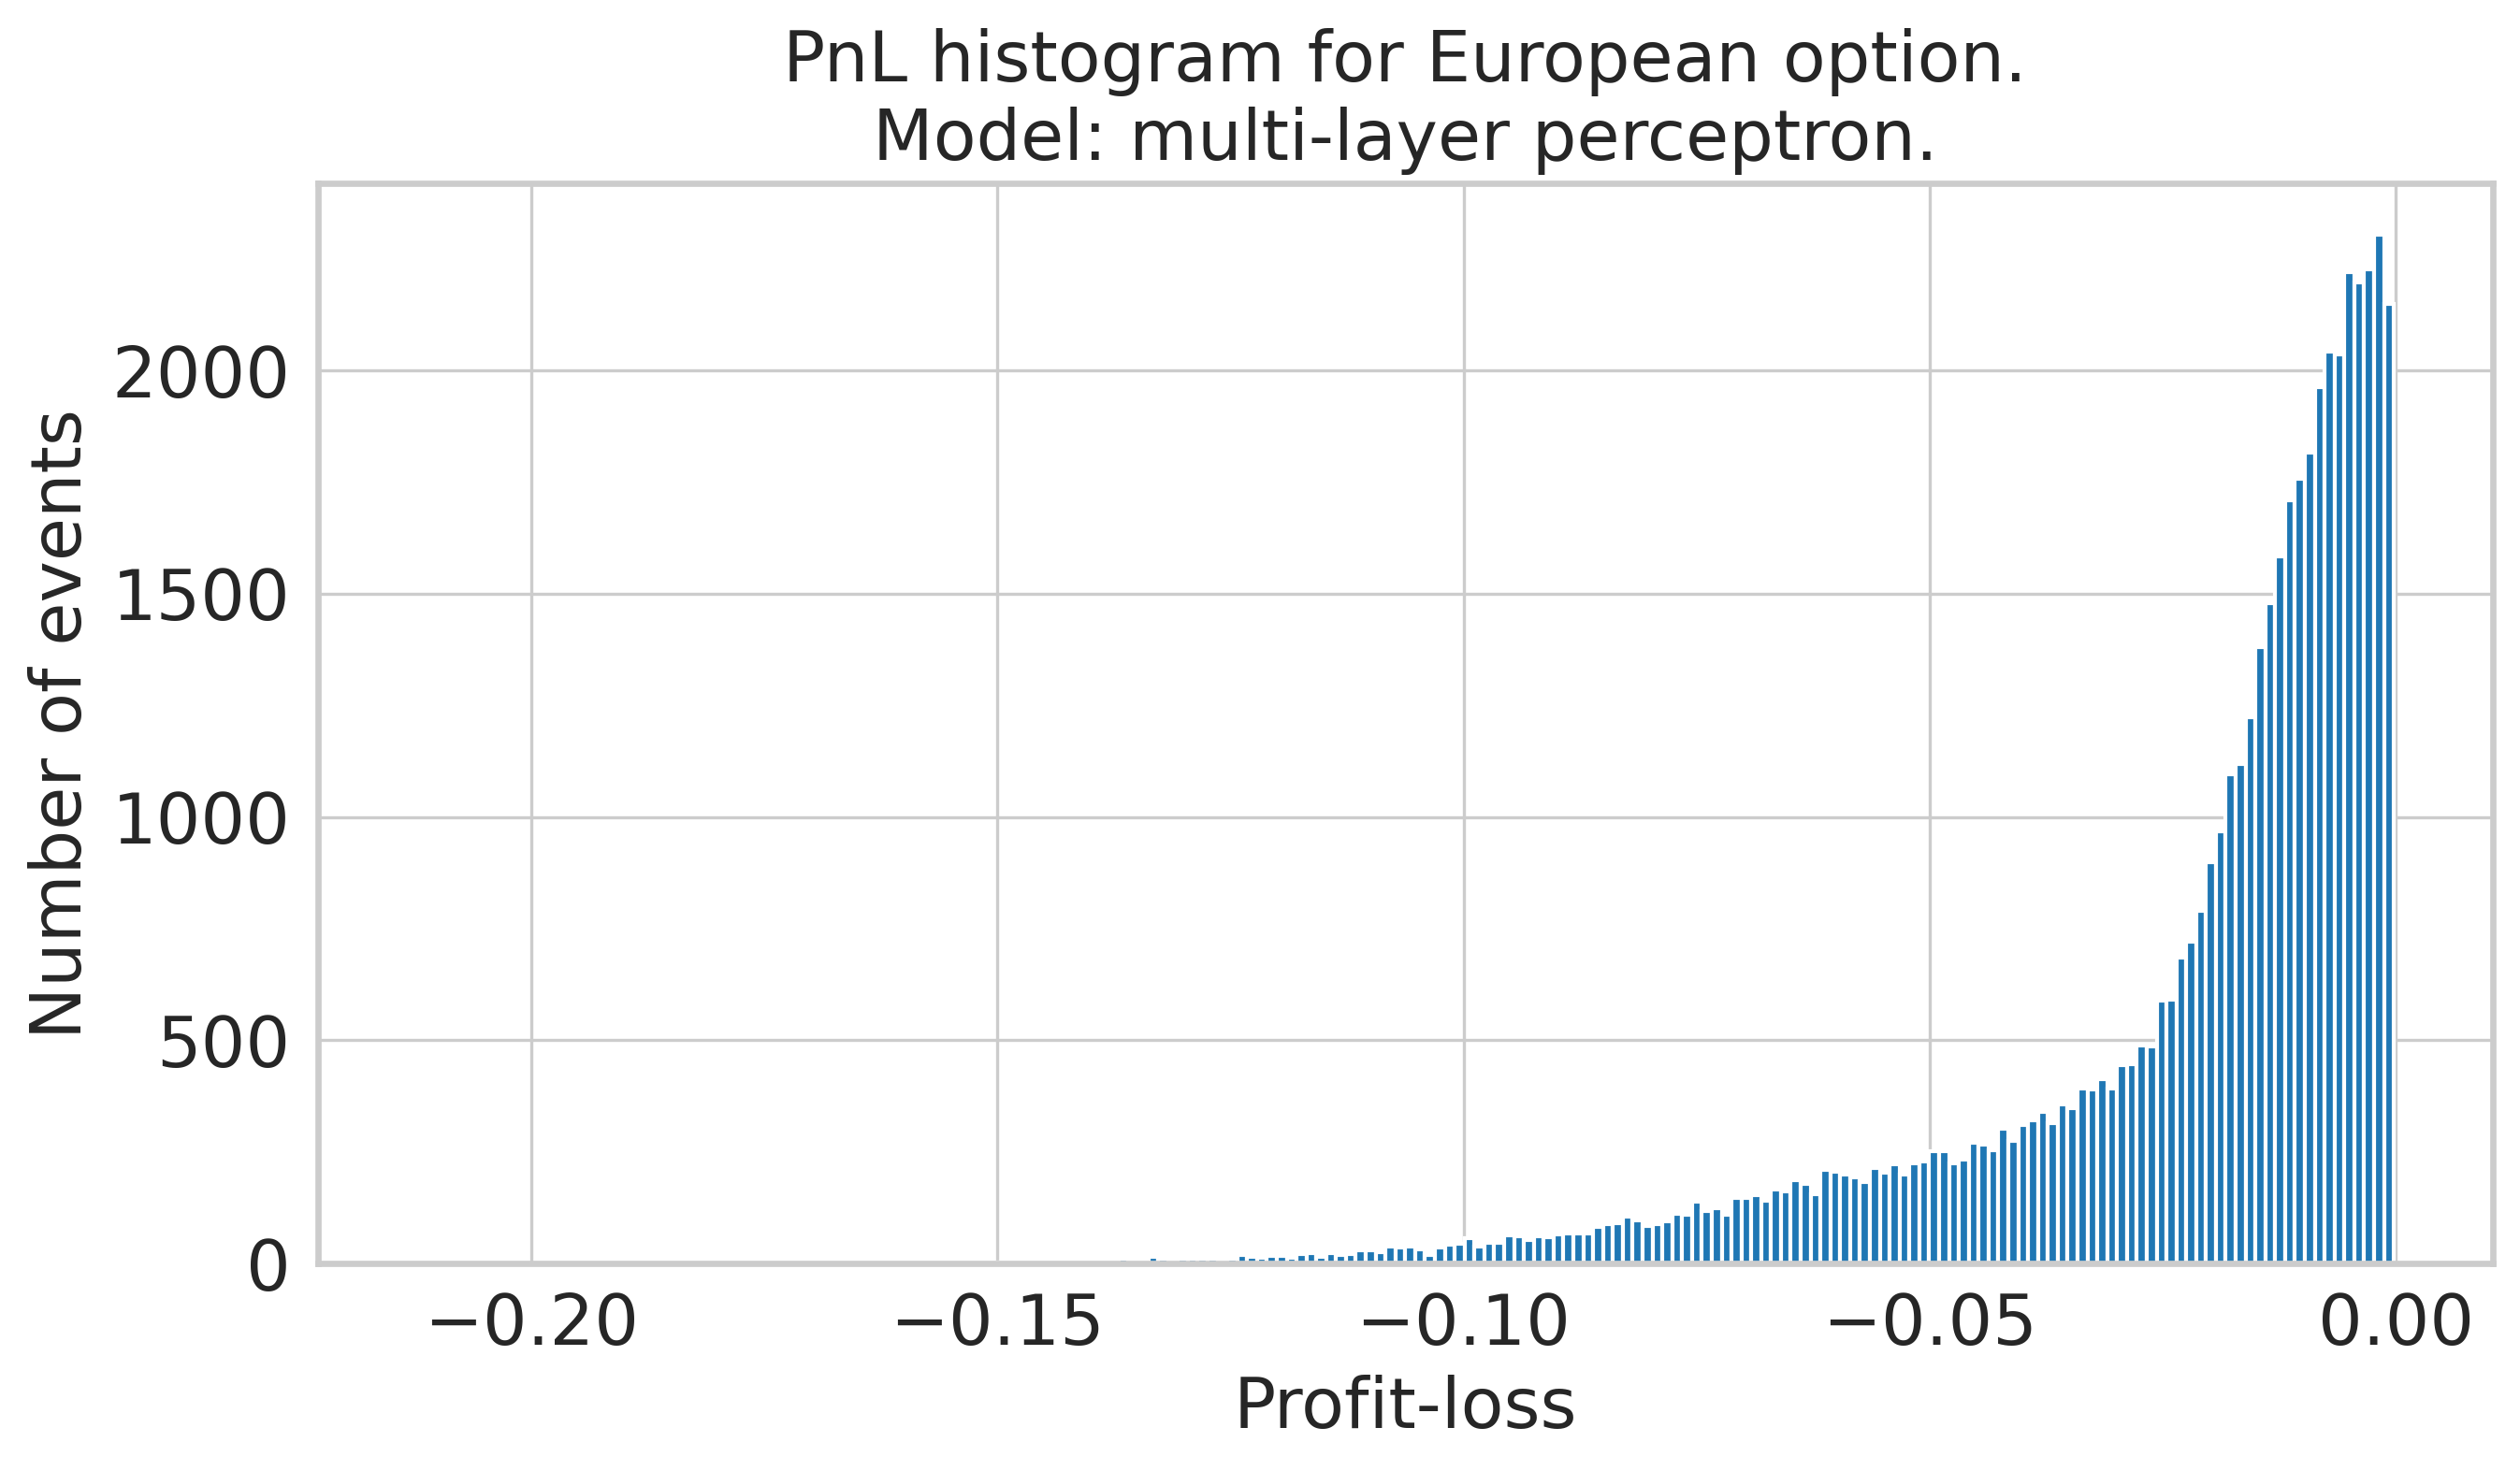

In [56]:
plot_pnl(hedger_mlp, derivative, n_paths=N_PATHS,
         title="PnL histogram for European option.\nModel: multi-layer perceptron.")

In [16]:
hedger_mlp.price(derivative)

tensor(0.0232, device='cuda:0')

# More Examples

## Black-Scholes' Delta-Hedging Strategy

In [17]:
model_bs = BlackScholes(derivative)
hedger_bs = Hedger(model_bs, inputs=model_bs.inputs()).to(DEVICE)

In [18]:
hedger_bs

Hedger(
  inputs=['log_moneyness', 'time_to_maturity', 'volatility']
  (model): BSEuropeanOption(strike=1.)
  (criterion): EntropicRiskMeasure()
)

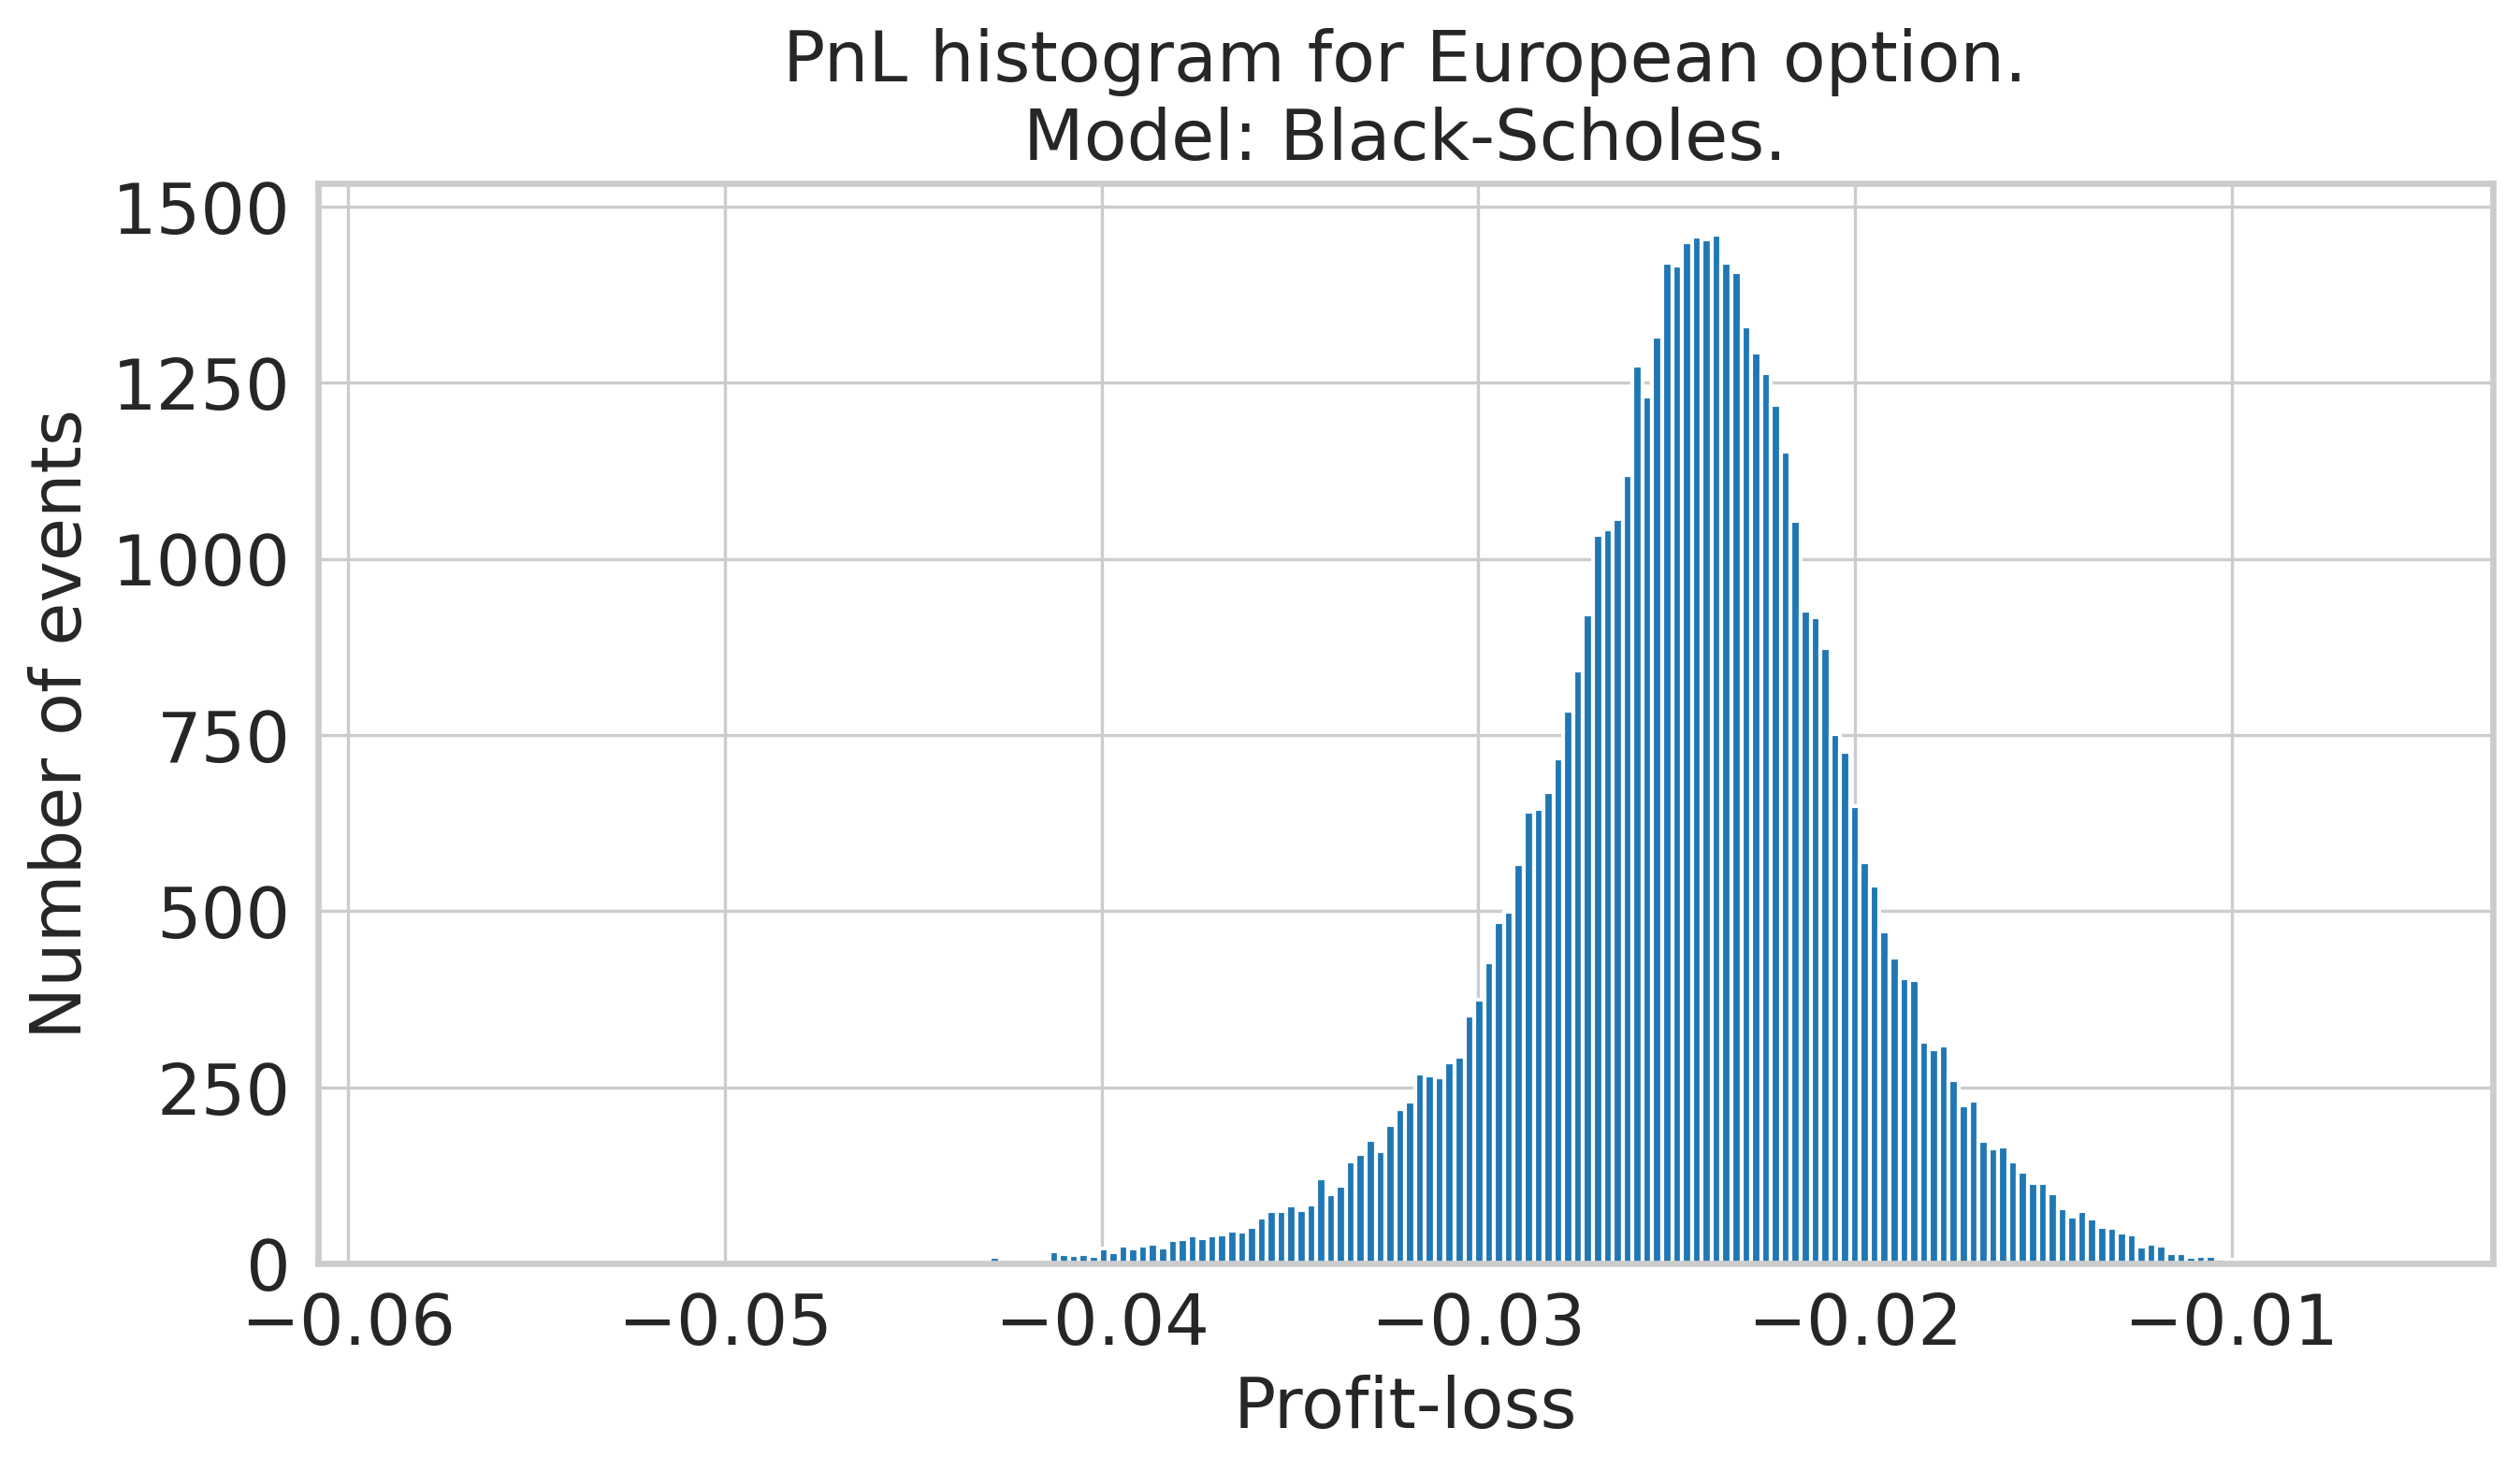

In [57]:
plot_pnl(hedger_bs, derivative, n_paths=N_PATHS,
         title="PnL histogram for European option.\nModel: Black-Scholes.")

In [20]:
hedger_bs.price(derivative)

tensor(0.0245, device='cuda:0')

## Whalley-Wilmott's Asymptotically Optimal Strategy for Small Costs

In [21]:
from pfhedge.nn import Hedger
from pfhedge.nn import WhalleyWilmott

model_ww = WhalleyWilmott(derivative)
hedger_ww = Hedger(model_ww, inputs=model_ww.inputs()).to(DEVICE)

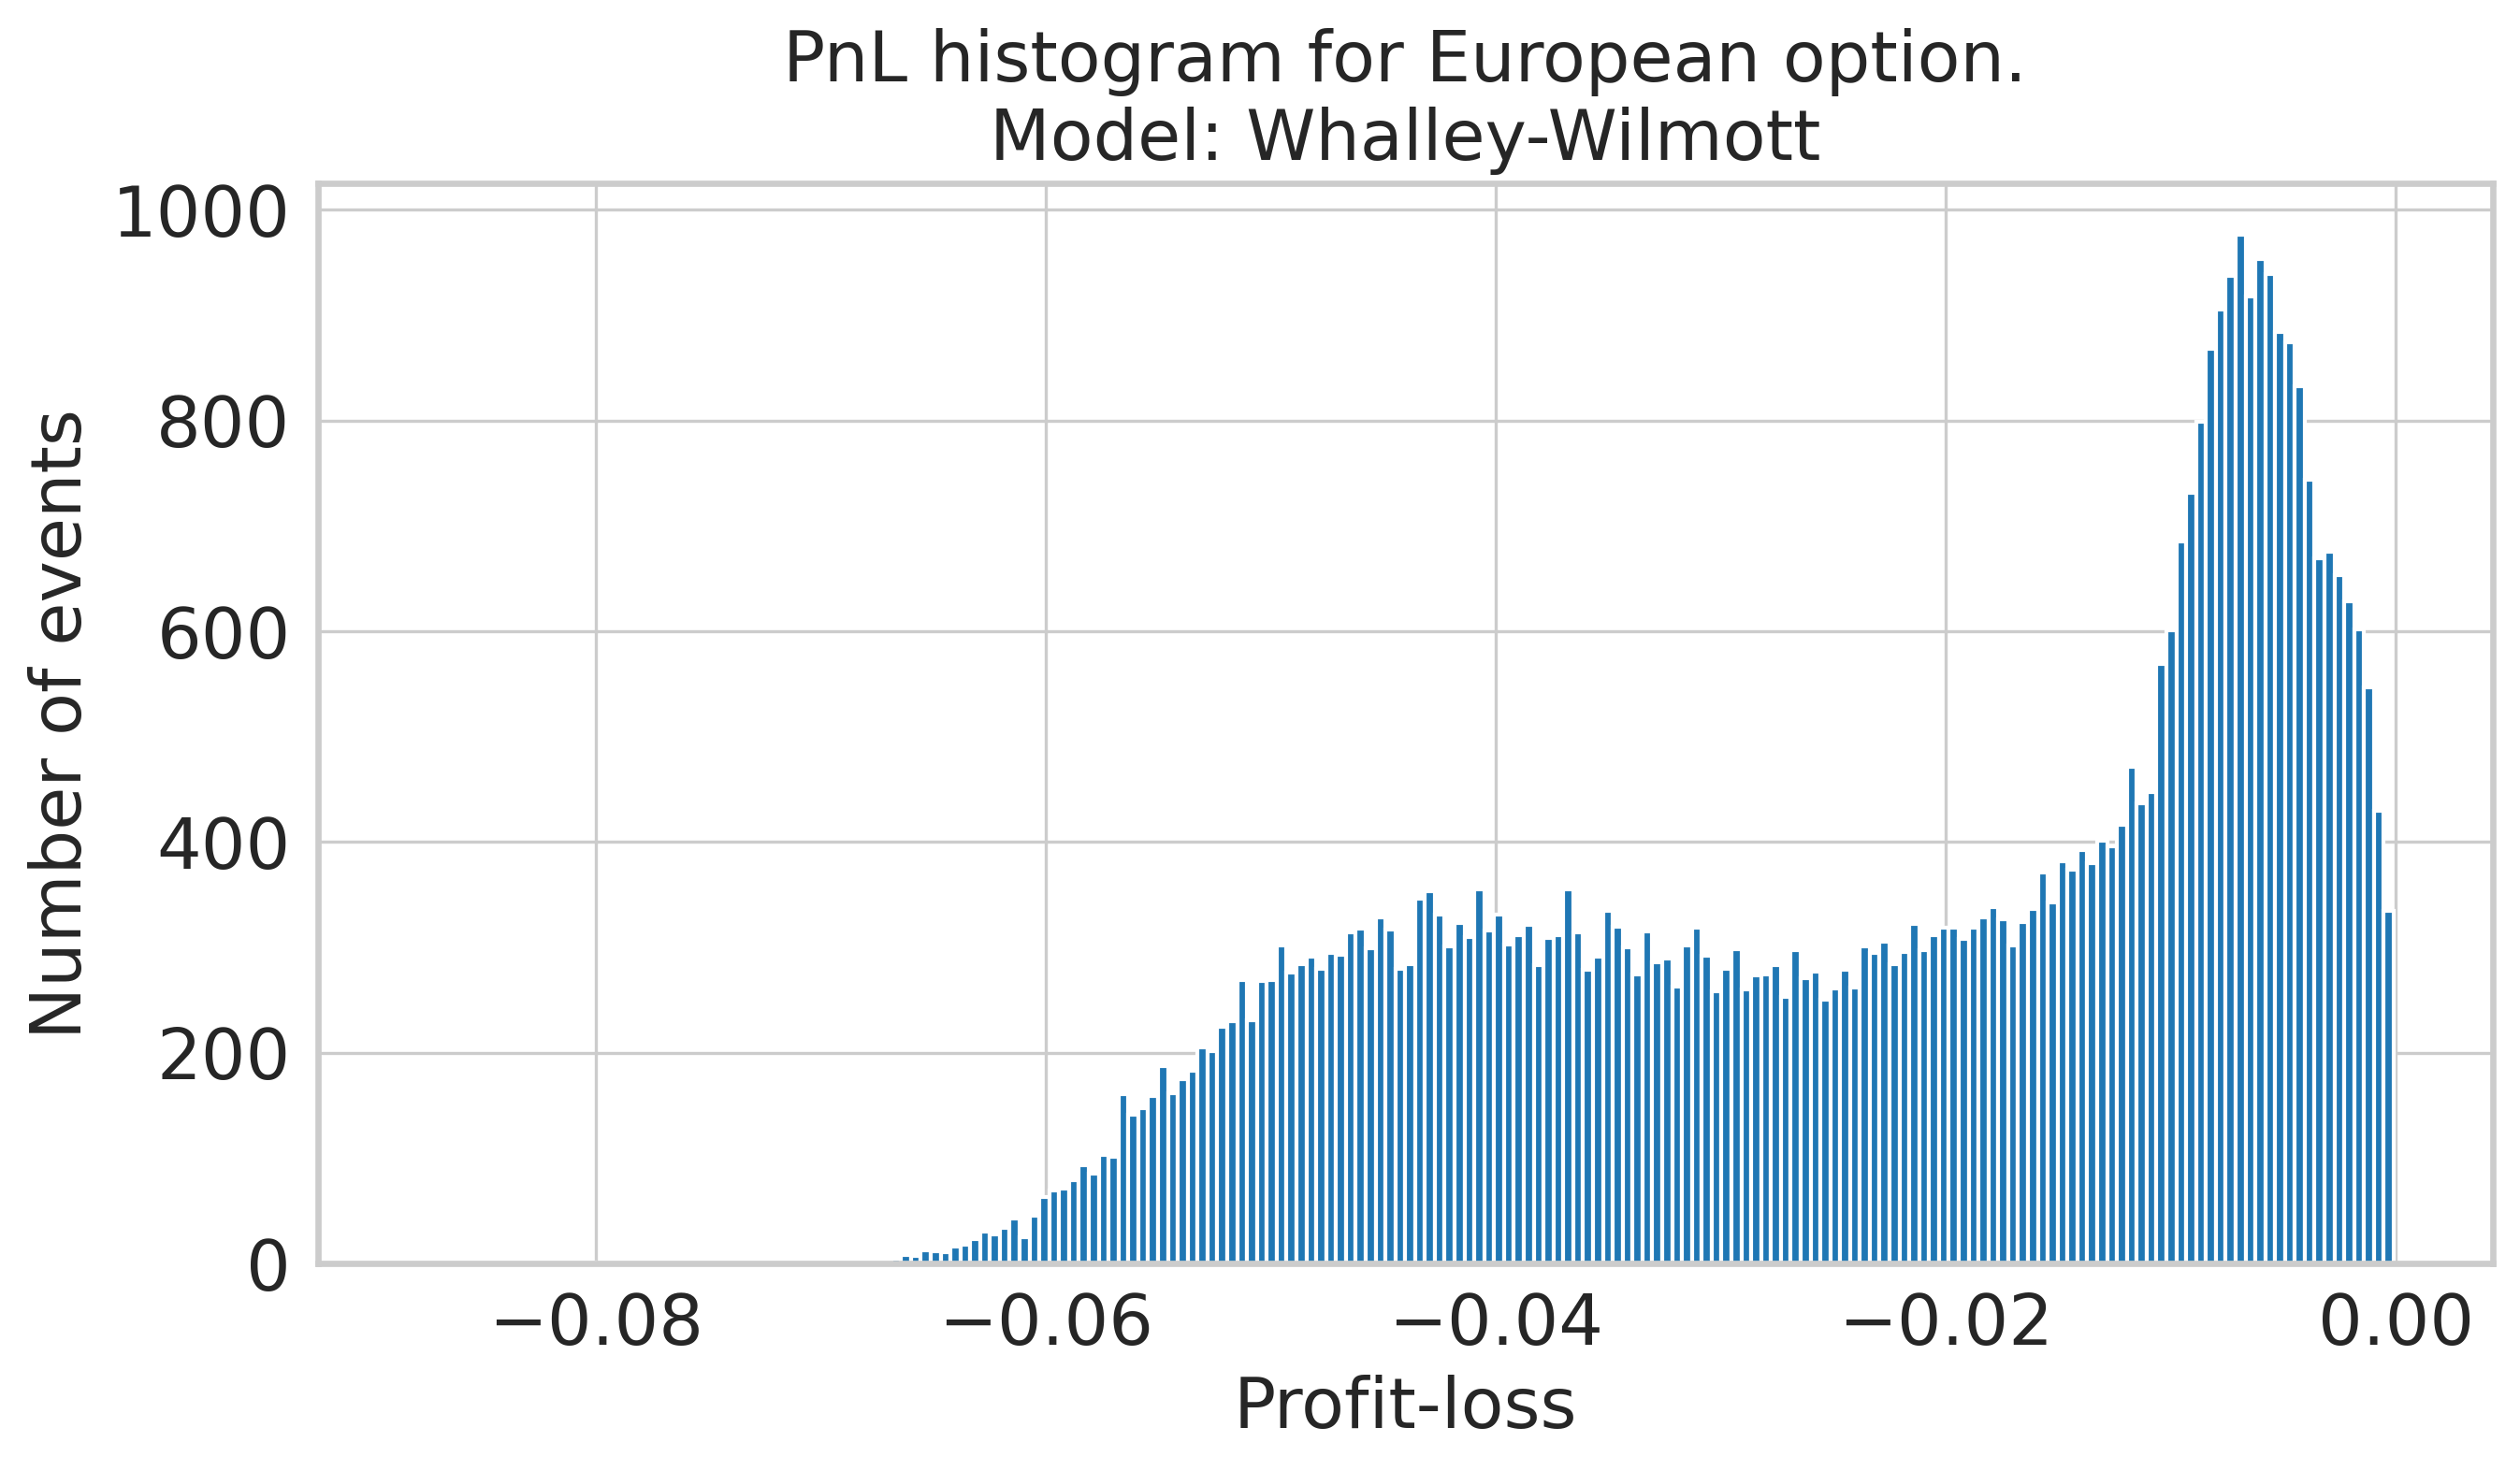

In [58]:
plot_pnl(hedger_ww, derivative, n_paths=N_PATHS,
         title="PnL histogram for European option.\nModel: Whalley-Wilmott")

In [23]:
hedger_ww.price(derivative)

tensor(0.0234, device='cuda:0')

## Your Own Module

In [19]:
class NoTransactionBandNet(Module):
    def __init__(self, derivative):
        super().__init__()

        self.delta = BlackScholes(derivative)
        self.mlp = MultiLayerPerceptron(out_features=2)
        self.clamp = Clamp()

    def inputs(self):
        return self.delta.inputs() + ["prev_hedge"]

    def forward(self, input: Tensor) -> Tensor:
        prev_hedge = input[..., [-1]]

        delta = self.delta(input[..., :-1])
        width = self.mlp(input[..., :-1])

        min = delta - fn.leaky_relu(width[..., [0]])
        max = delta + fn.leaky_relu(width[..., [1]])

        return self.clamp(prev_hedge, min=min, max=max)

In [25]:
model_ntband = NoTransactionBandNet(derivative)
hedger_ntband = Hedger(model_ntband, inputs=model_ntband.inputs()).to(DEVICE)

In [26]:
history_ntband = hedger_ntband.fit(derivative, n_epochs=N_EPOCHS, n_paths=N_PATHS, n_times=20)

Loss=0.0231: 100%|██████████| 200/200 [03:54<00:00,  1.17s/it]


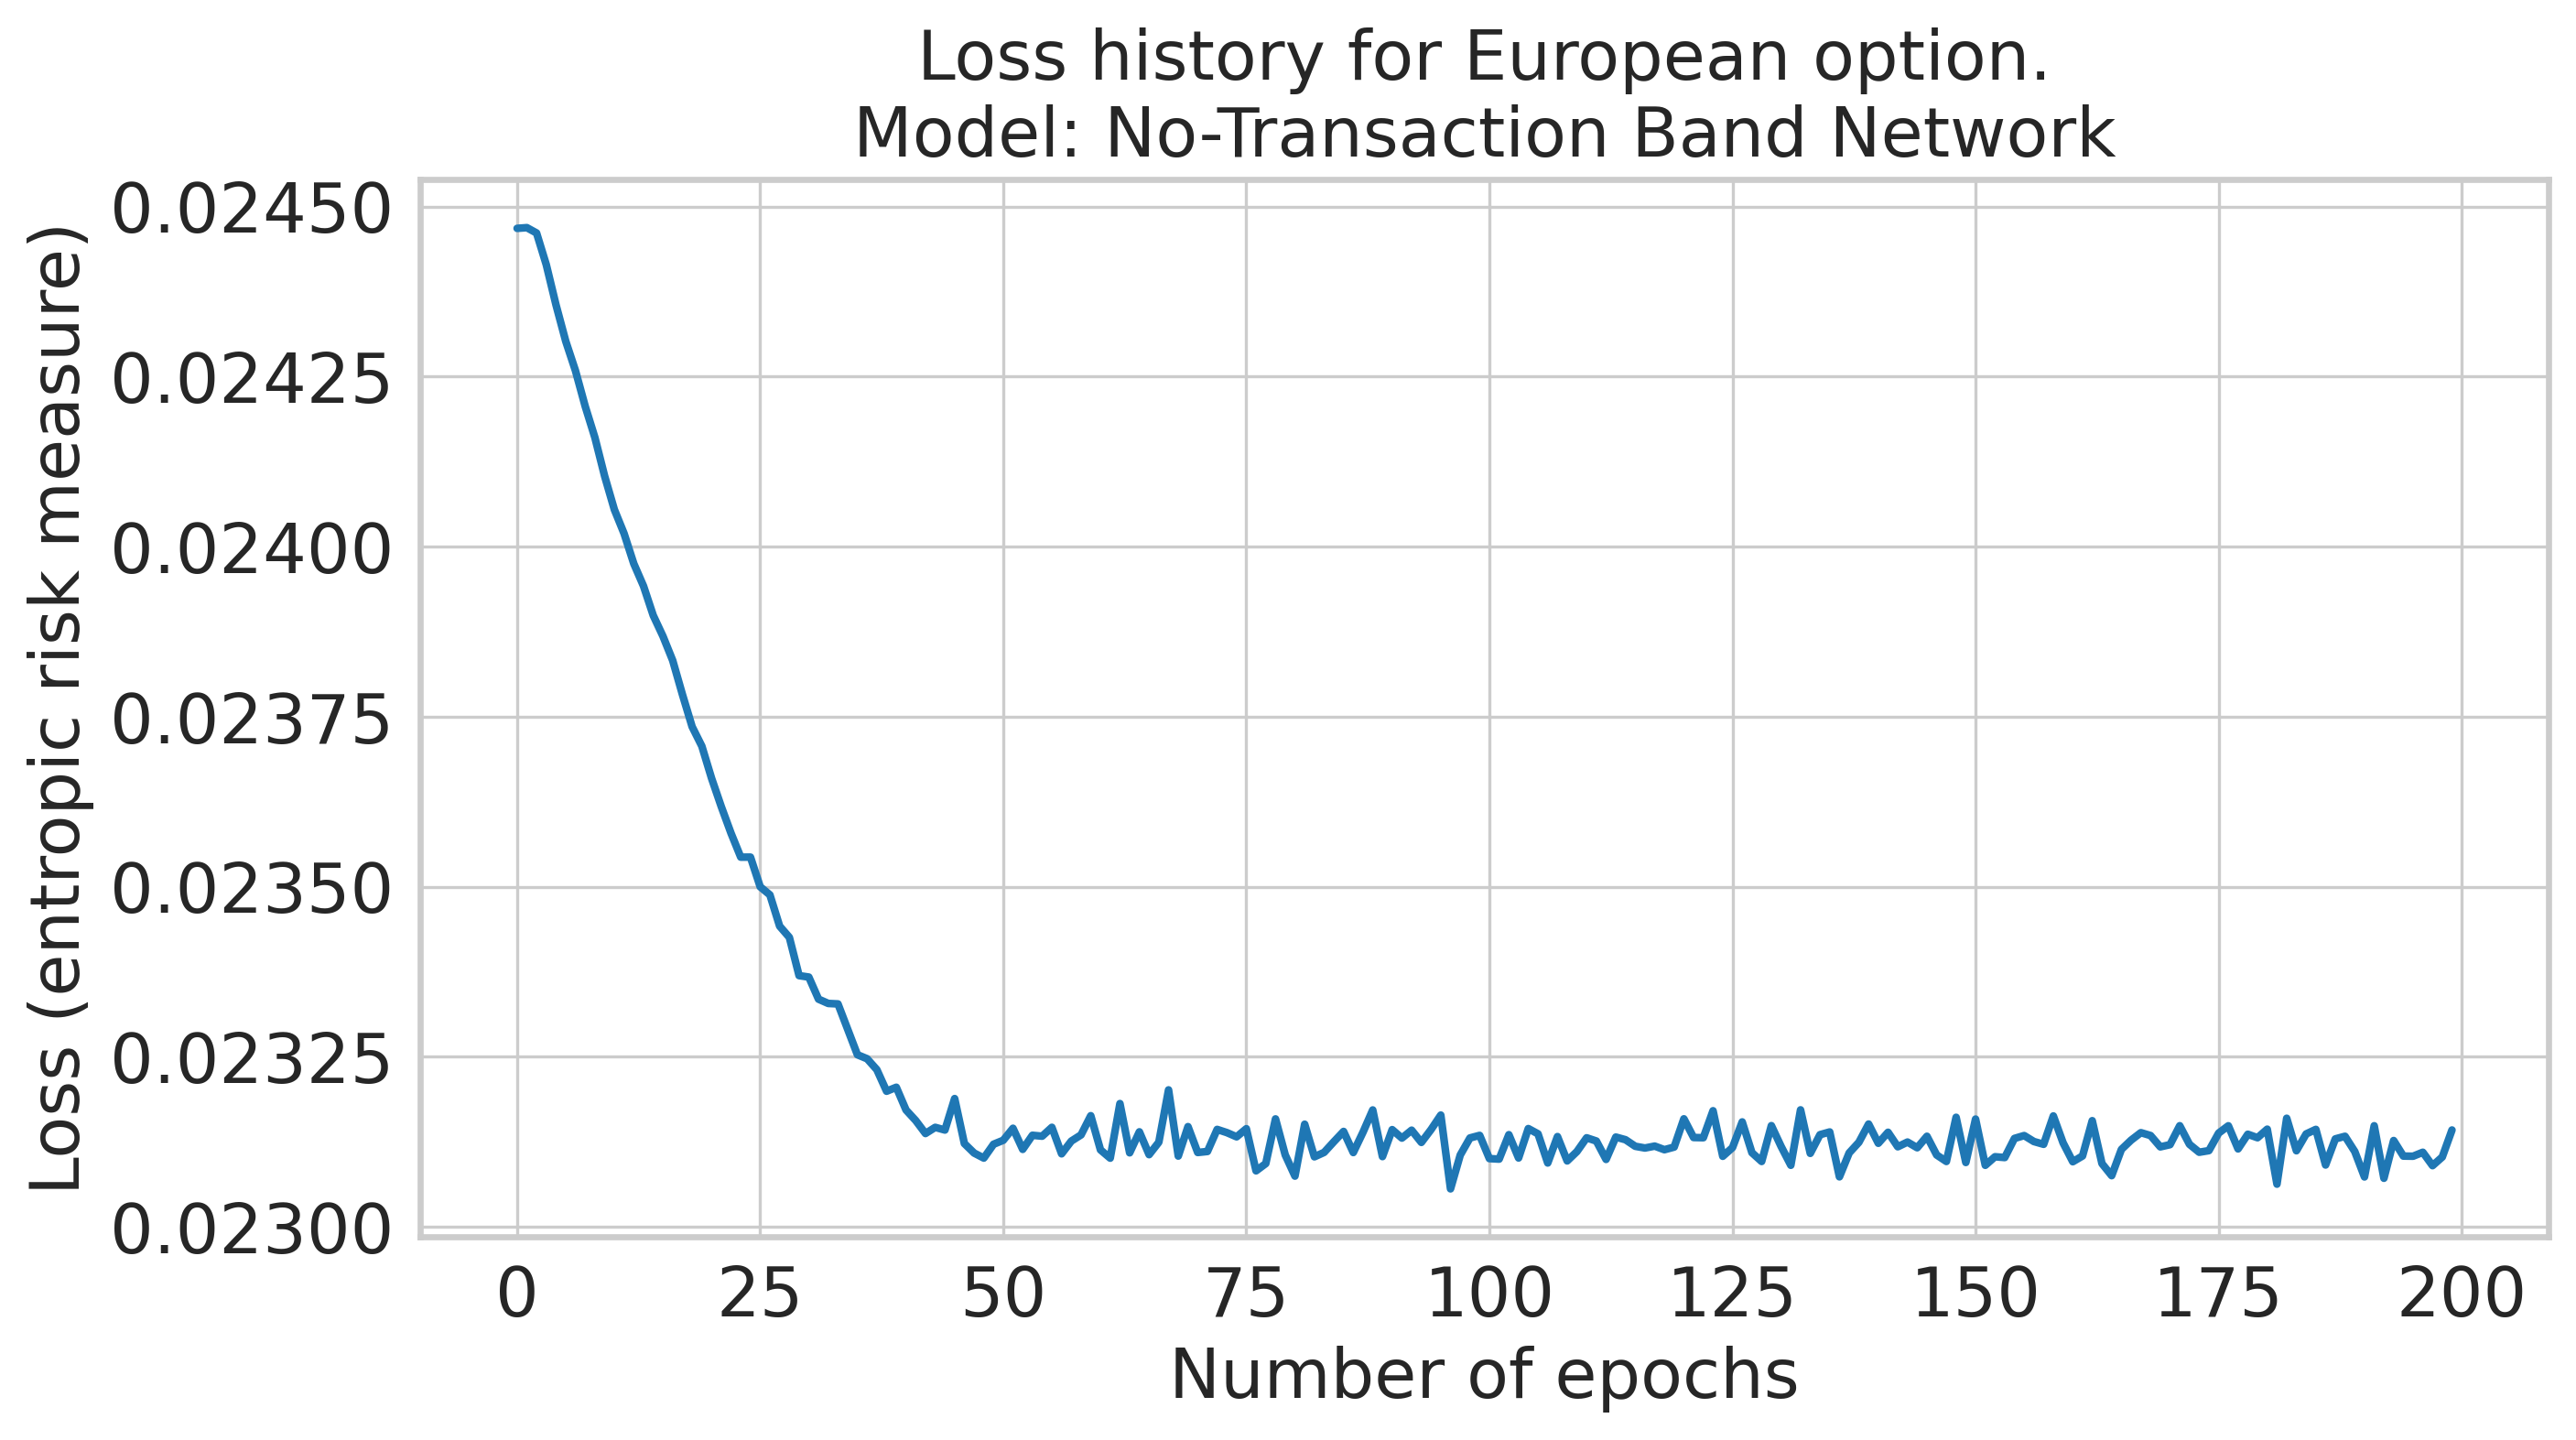

In [59]:
plot_history(history_ntband, "Loss history for European option.\nModel: No-Transaction Band Network")

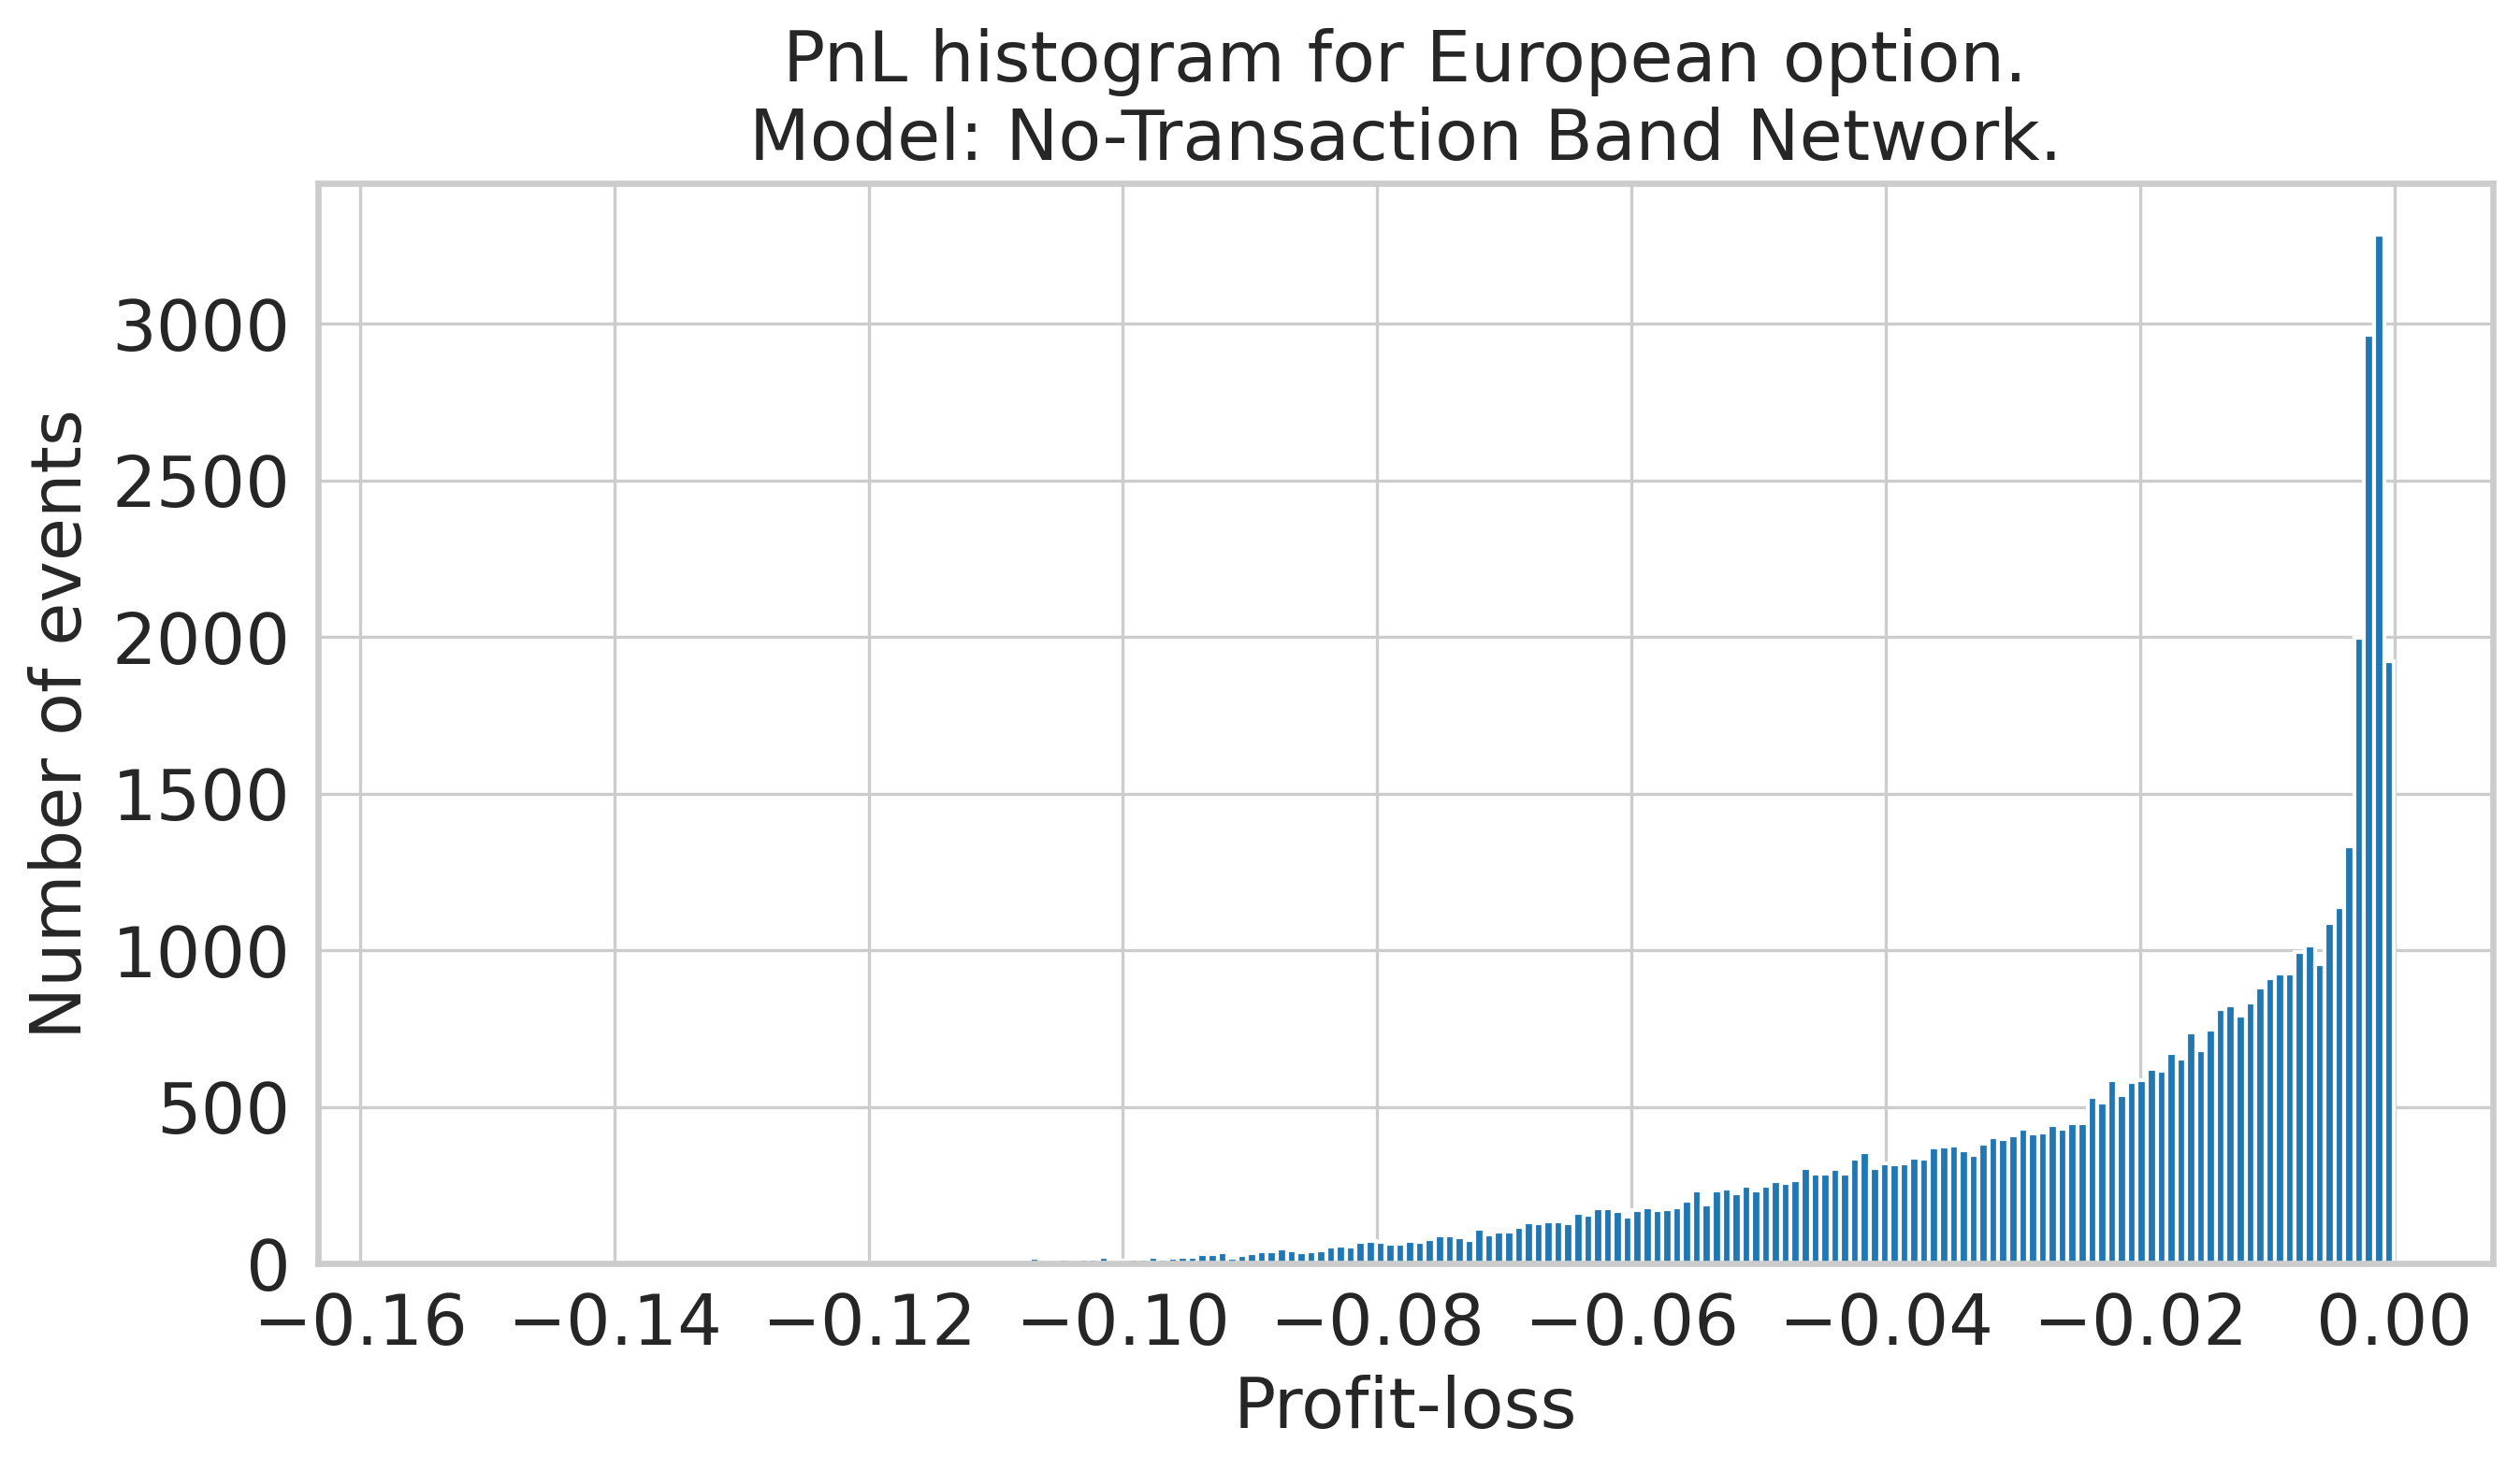

In [60]:
plot_pnl(hedger_ntband, derivative, n_paths=N_PATHS,
         title="PnL histogram for European option.\nModel: No-Transaction Band Network.")

In [29]:
hedger_ntband.price(derivative)

tensor(0.0231, device='cuda:0')

## Use Expected Shortfall as a Loss function

In [32]:
# Expected shortfall with the quantile level of 10%
expected_shortfall = ExpectedShortfall(0.1)

model_ntband_es = NoTransactionBandNet(derivative)
hedger_ntband_es = Hedger(model_ntband_es, inputs=model_ntband_es.inputs(), criterion=expected_shortfall).to(DEVICE)

/home/mas/.cache/pypoetry/virtualenvs/pfhedge-kZR3kgmR-py3.10/lib/python3.10/site-packages/torch/nn/modules/lazy.py:178: UserWarning:

Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.



In [33]:
history_ntband_es = hedger_ntband_es.fit(derivative, n_epochs=N_EPOCHS, n_paths=N_PATHS, n_times=20)

Loss=0.0324: 100%|██████████| 200/200 [03:16<00:00,  1.02it/s]


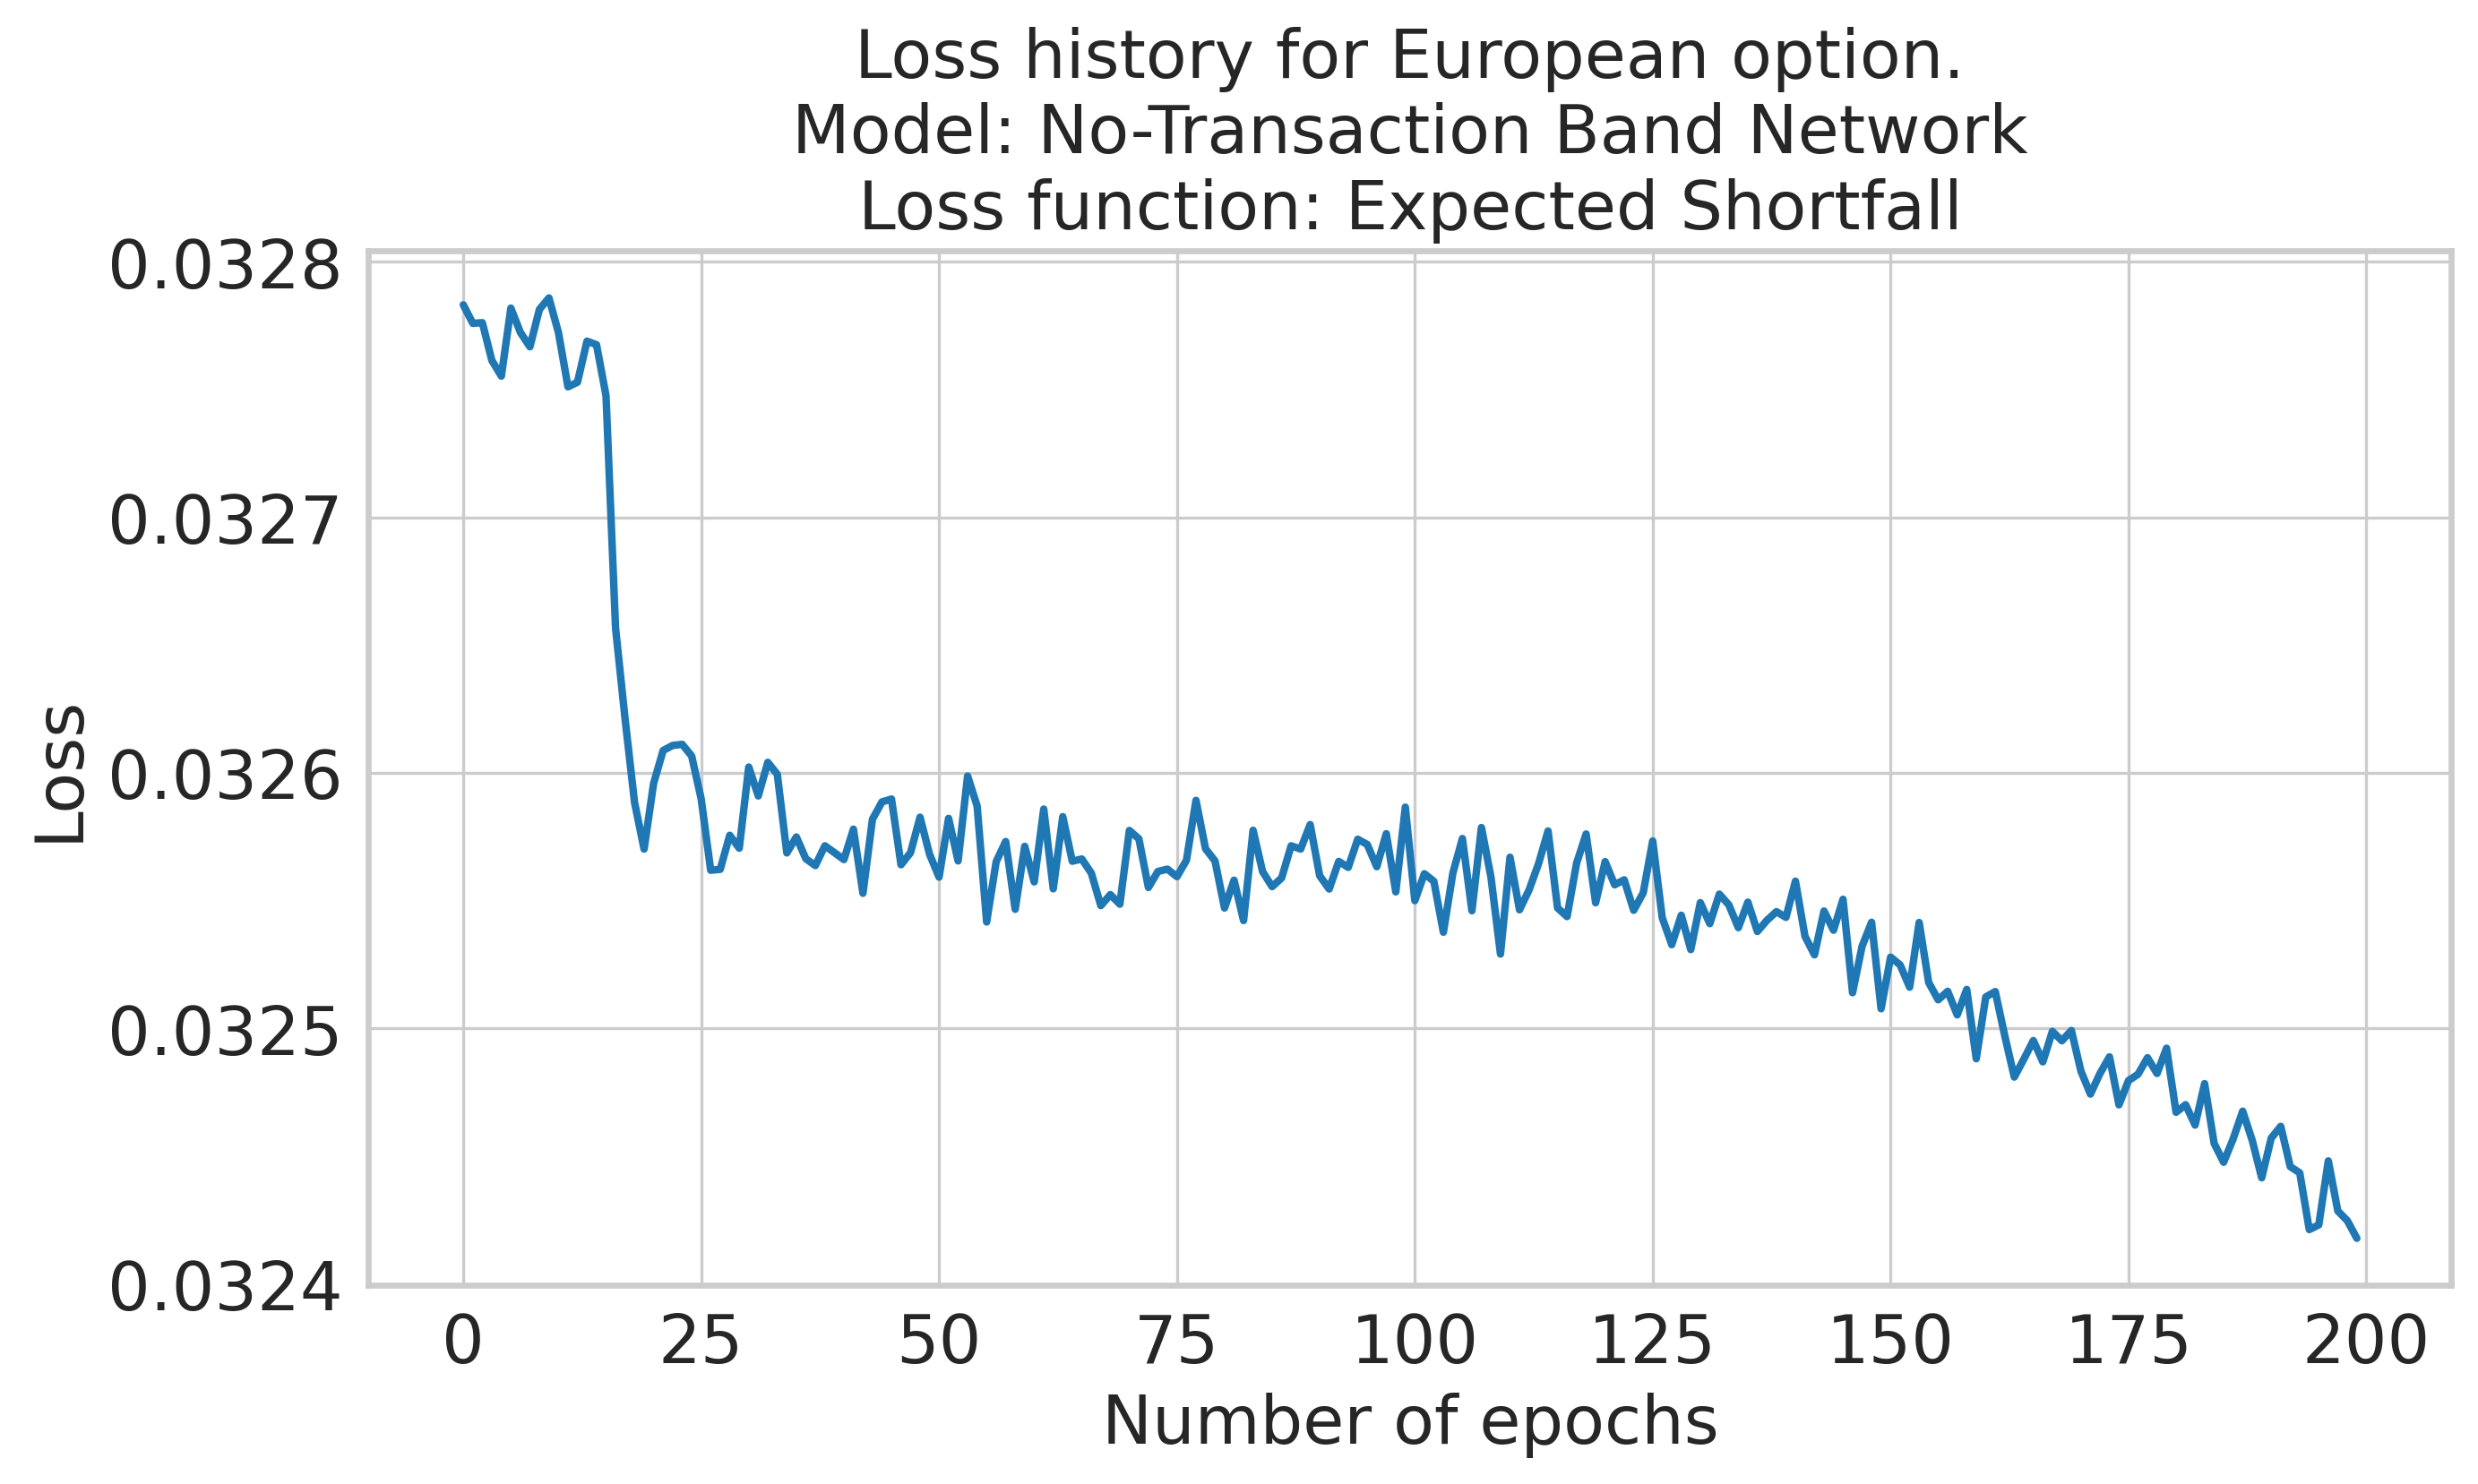

In [38]:
plot_history(history_ntband_es, "Loss history for European option.\nModel: No-Transaction Band Network\n"
                      "Loss function: Expected Shortfall")

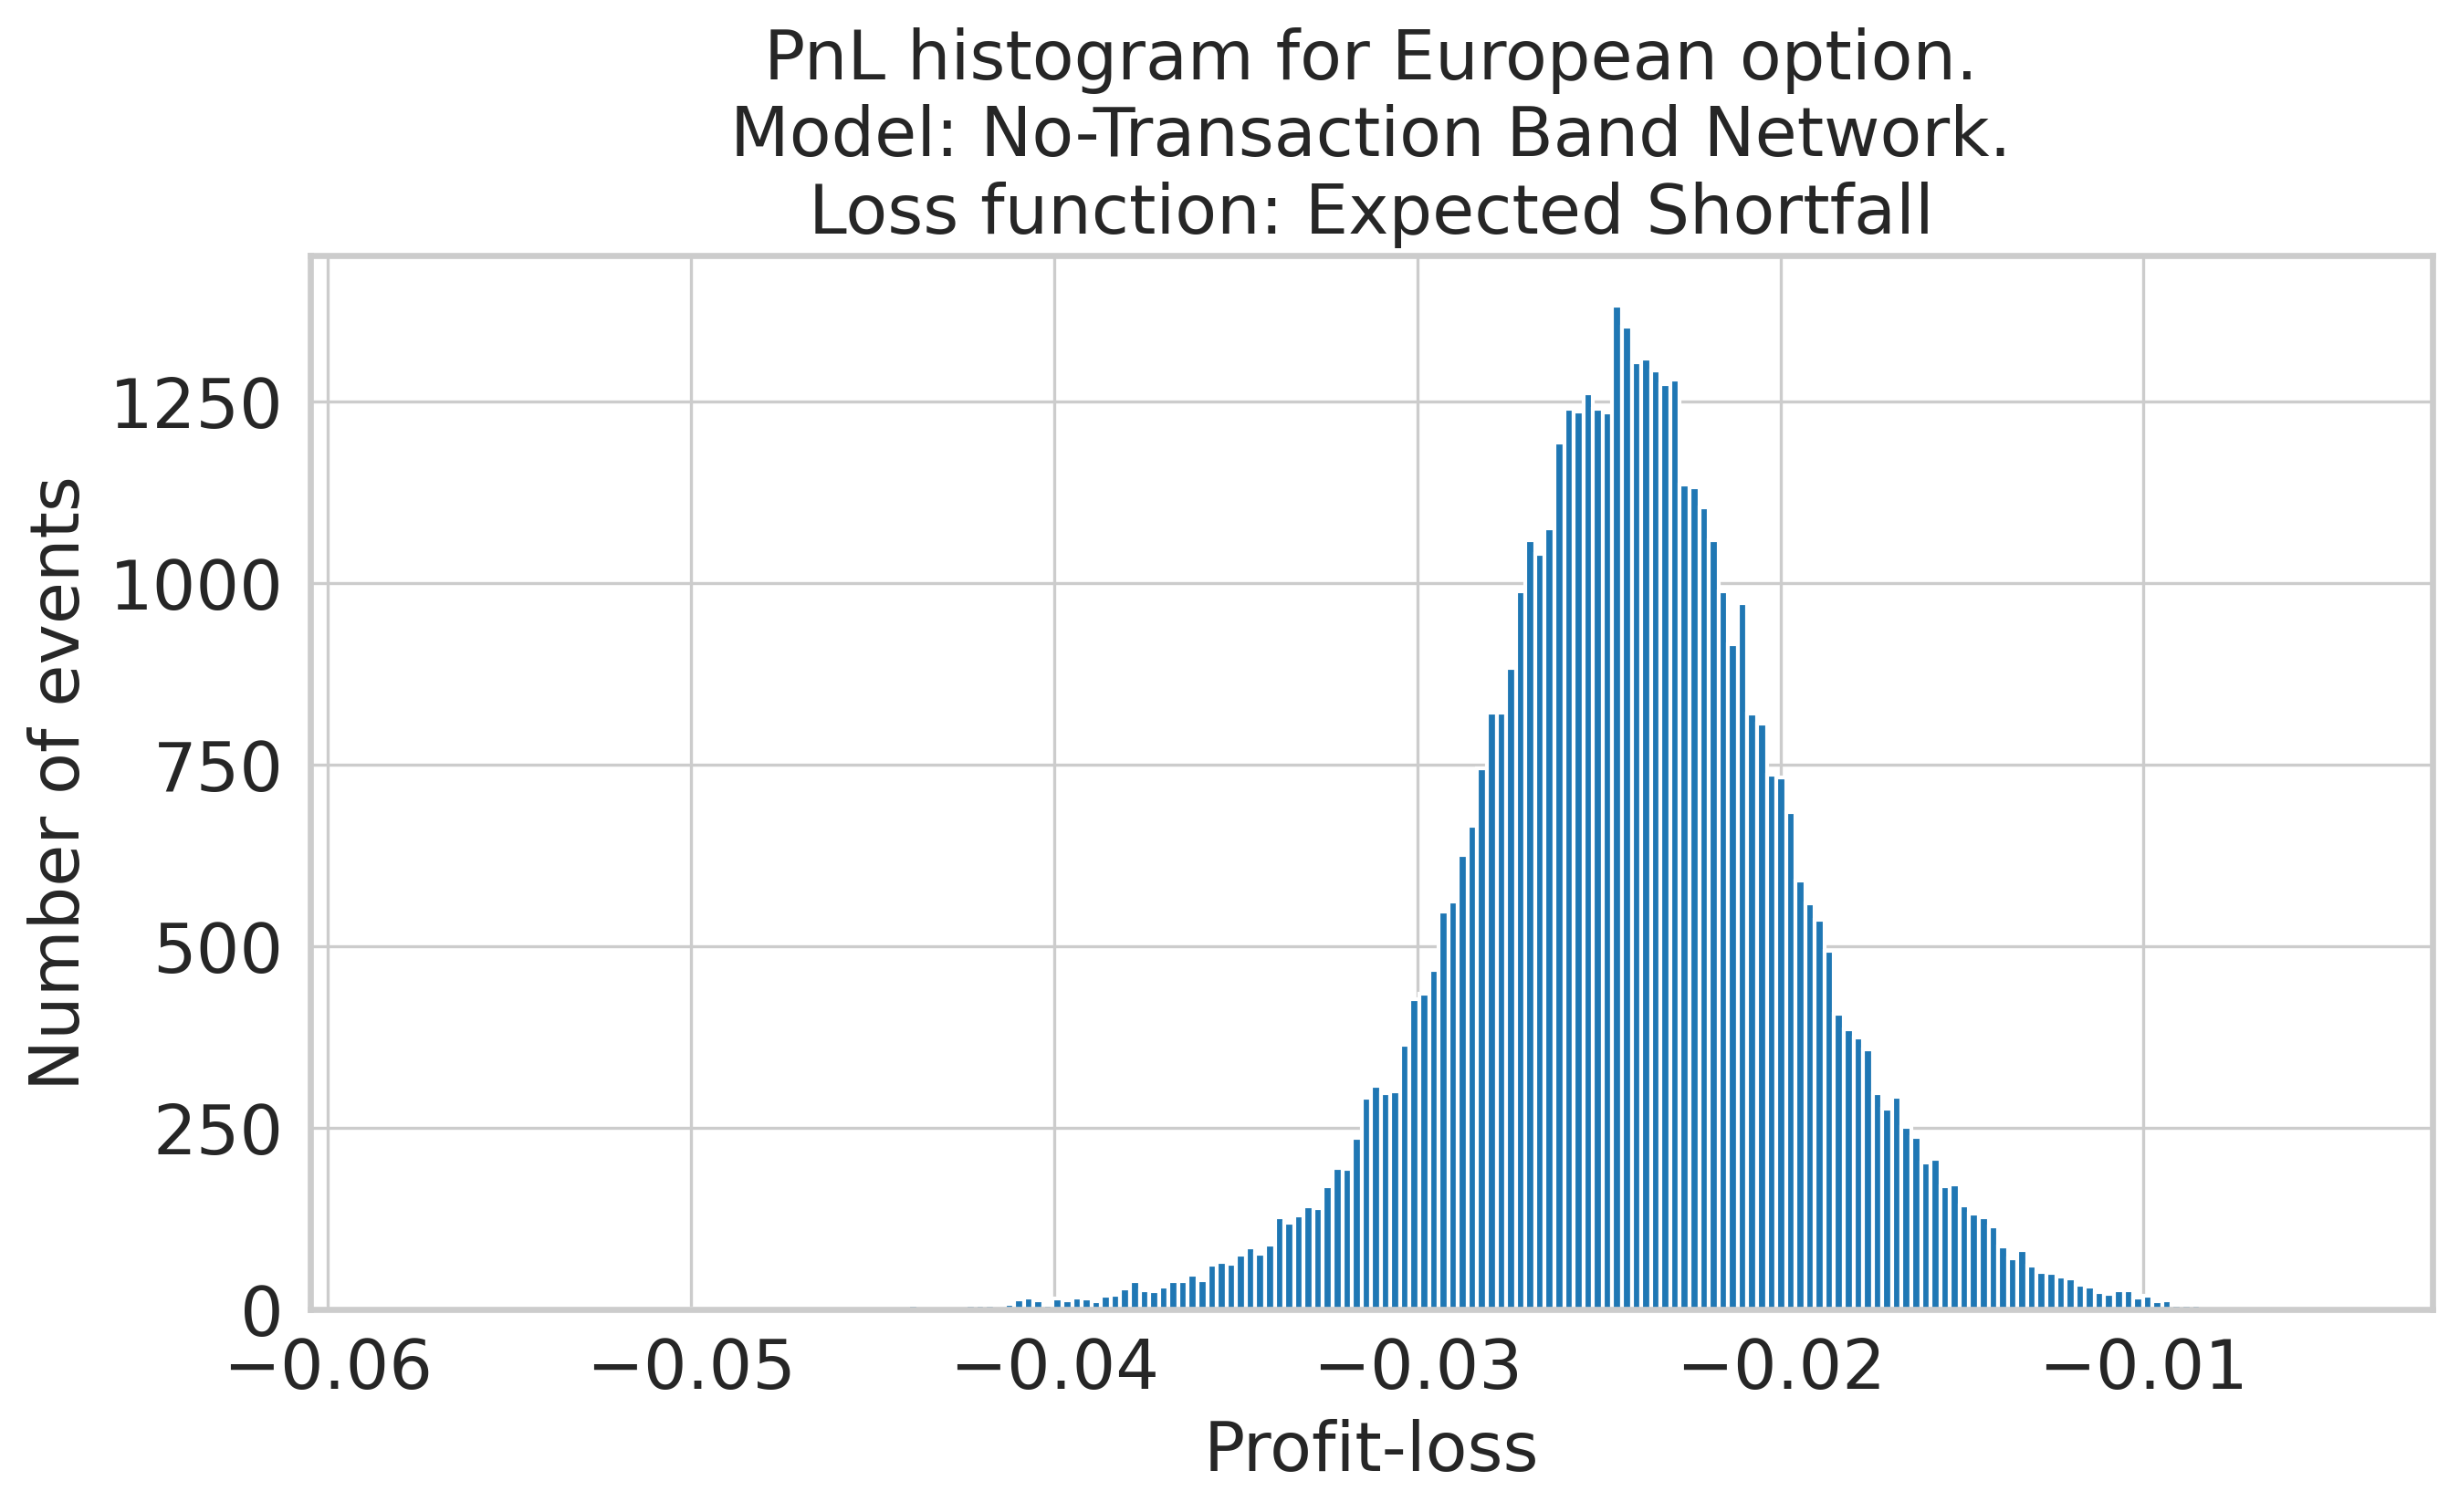

In [39]:
plot_pnl(hedger_ntband_es, derivative, n_paths=N_PATHS,
         title="PnL histogram for European option.\nModel: No-Transaction Band Network.\n"
               "Loss function: Expected Shortfall")

In [35]:
hedger_ntband_es.price(derivative)

tensor(0.0318, device='cuda:0')

## Merton jump-diffusion stock

In [13]:
stock_jump = MertonJumpStock(cost=1e-3, device=DEVICE)
derivative_jump = EuropeanOption(stock_jump)

### Multi-Layer Perceptron

In [14]:
model_mlp_jump = MultiLayerPerceptron()
hedger_mlp_jump = Hedger(
    model_mlp_jump, inputs=["log_moneyness", "expiry_time", "volatility", "prev_hedge"]
).to(DEVICE)

/home/mas/.cache/pypoetry/virtualenvs/pfhedge-kZR3kgmR-py3.10/lib/python3.10/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [15]:
history_mlp_jump = hedger_mlp_jump.fit(derivative_jump, n_epochs=N_EPOCHS, n_paths=N_PATHS, n_times=20)

Loss=0.0255: 100%|██████████| 200/200 [03:43<00:00,  1.12s/it]


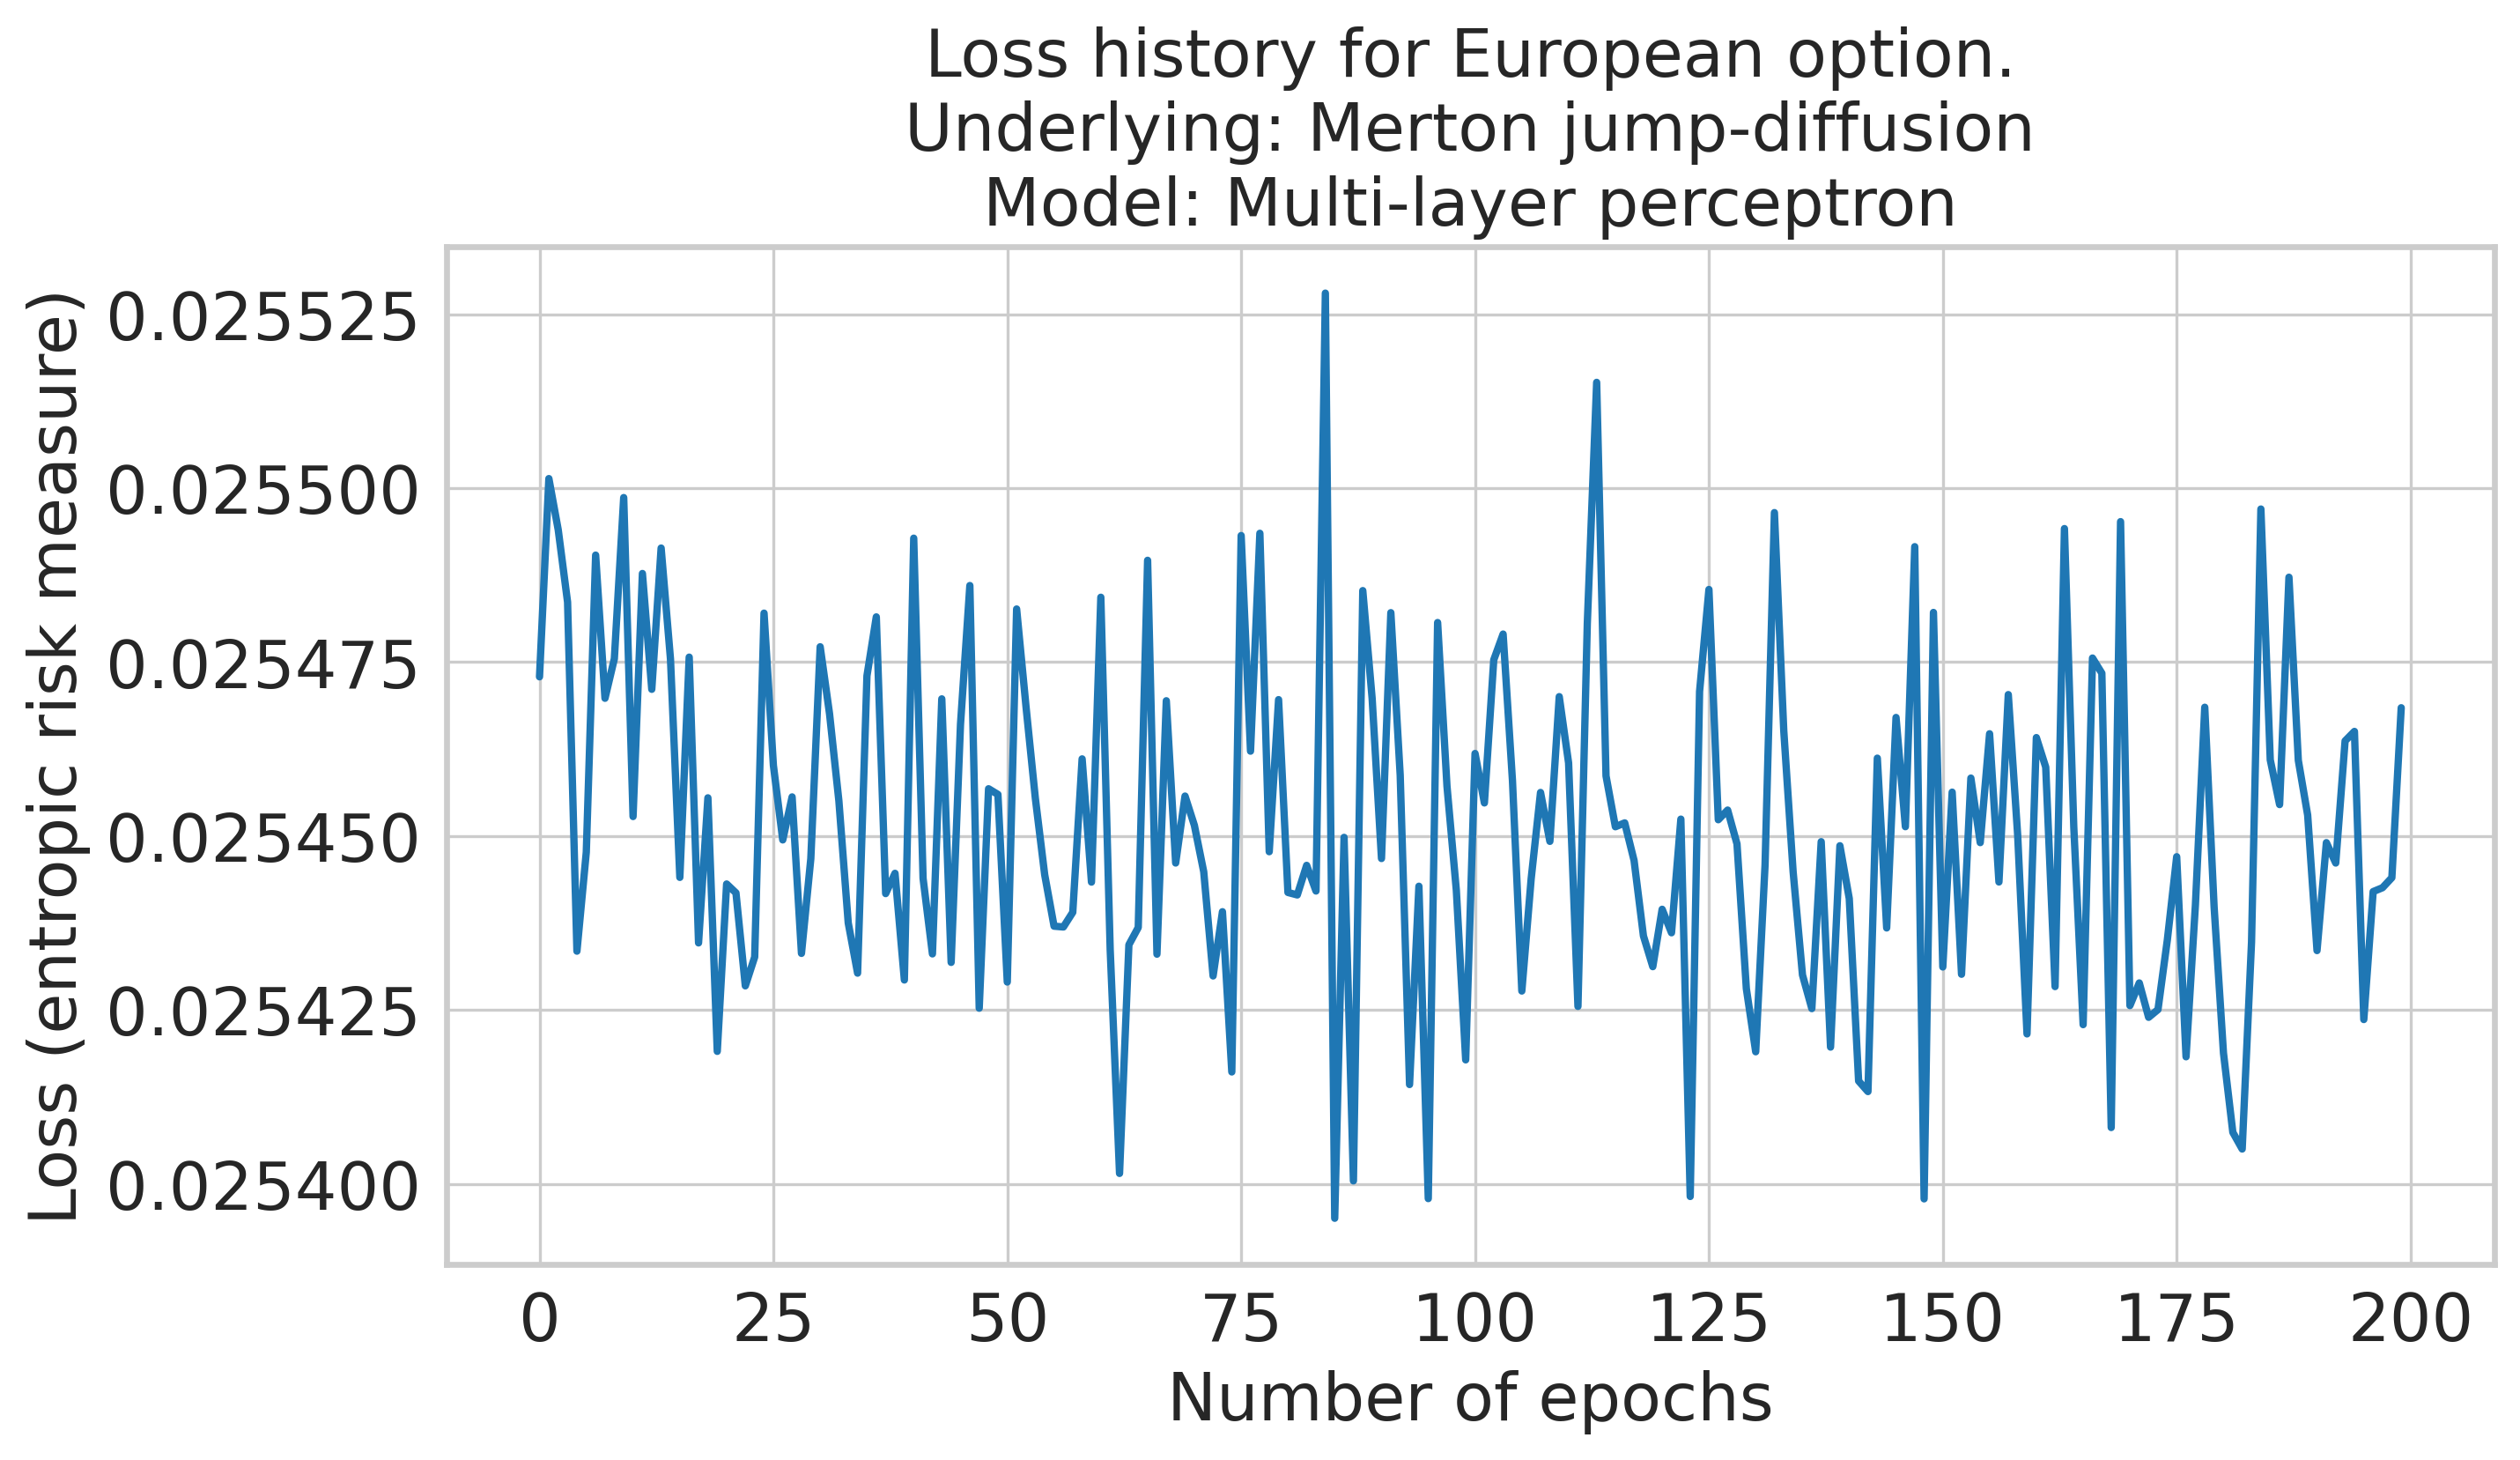

In [27]:
plot_history(history_mlp_jump, "Loss history for European option.\n"
                               "Underlying: Merton jump-diffusion\n"
                               "Model: Multi-layer perceptron")

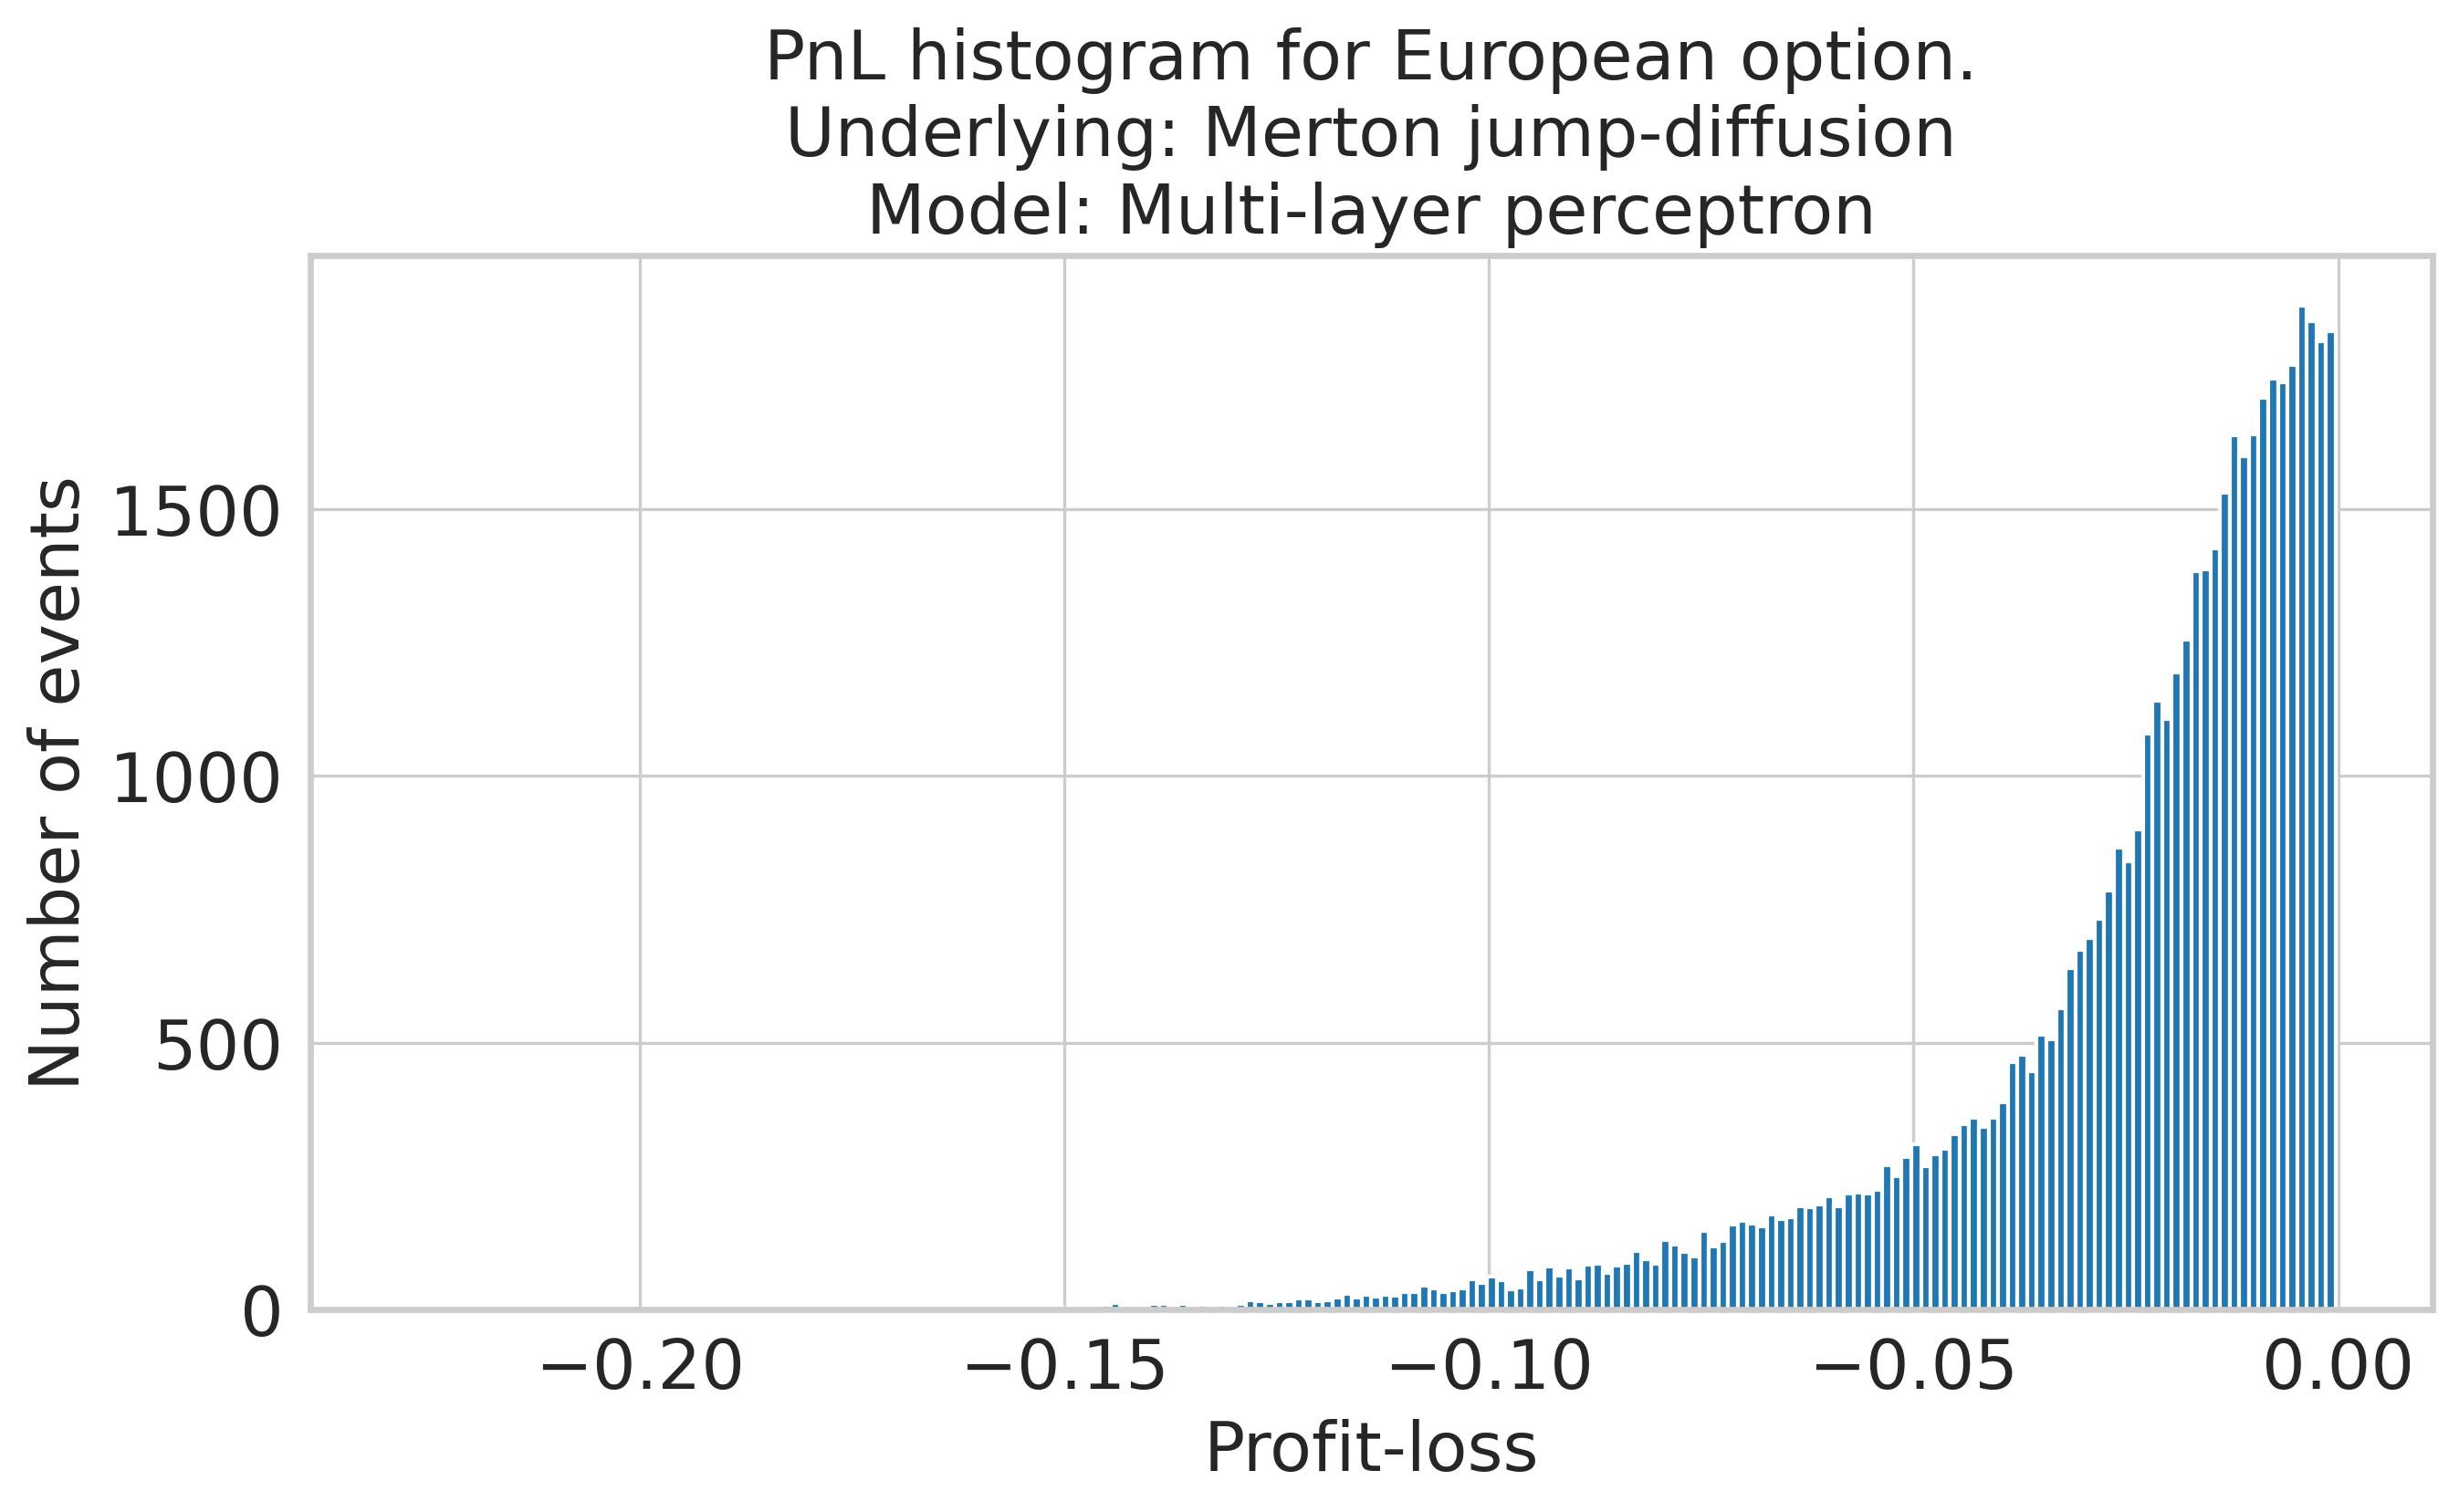

In [28]:
plot_pnl(hedger_mlp_jump, derivative_jump, n_paths=N_PATHS,
         title="PnL histogram for European option.\n"
                "Underlying: Merton jump-diffusion\n"
                "Model: Multi-layer perceptron")

In [43]:
hedger_mlp_jump.price(derivative_jump)

tensor(0.0247, device='cuda:0')

### No-Transaction Band Network

In [20]:
model_ntband_jump = NoTransactionBandNet(derivative_jump)
hedger_ntband_jump = Hedger(model_ntband_jump, inputs=model_ntband_jump.inputs()).to(DEVICE)

/home/mas/.cache/pypoetry/virtualenvs/pfhedge-kZR3kgmR-py3.10/lib/python3.10/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [21]:
history_ntband_jump = hedger_ntband_jump.fit(derivative_jump, n_epochs=N_EPOCHS, n_paths=N_PATHS, n_times=20)

Loss=0.0255: 100%|██████████| 200/200 [04:57<00:00,  1.49s/it]


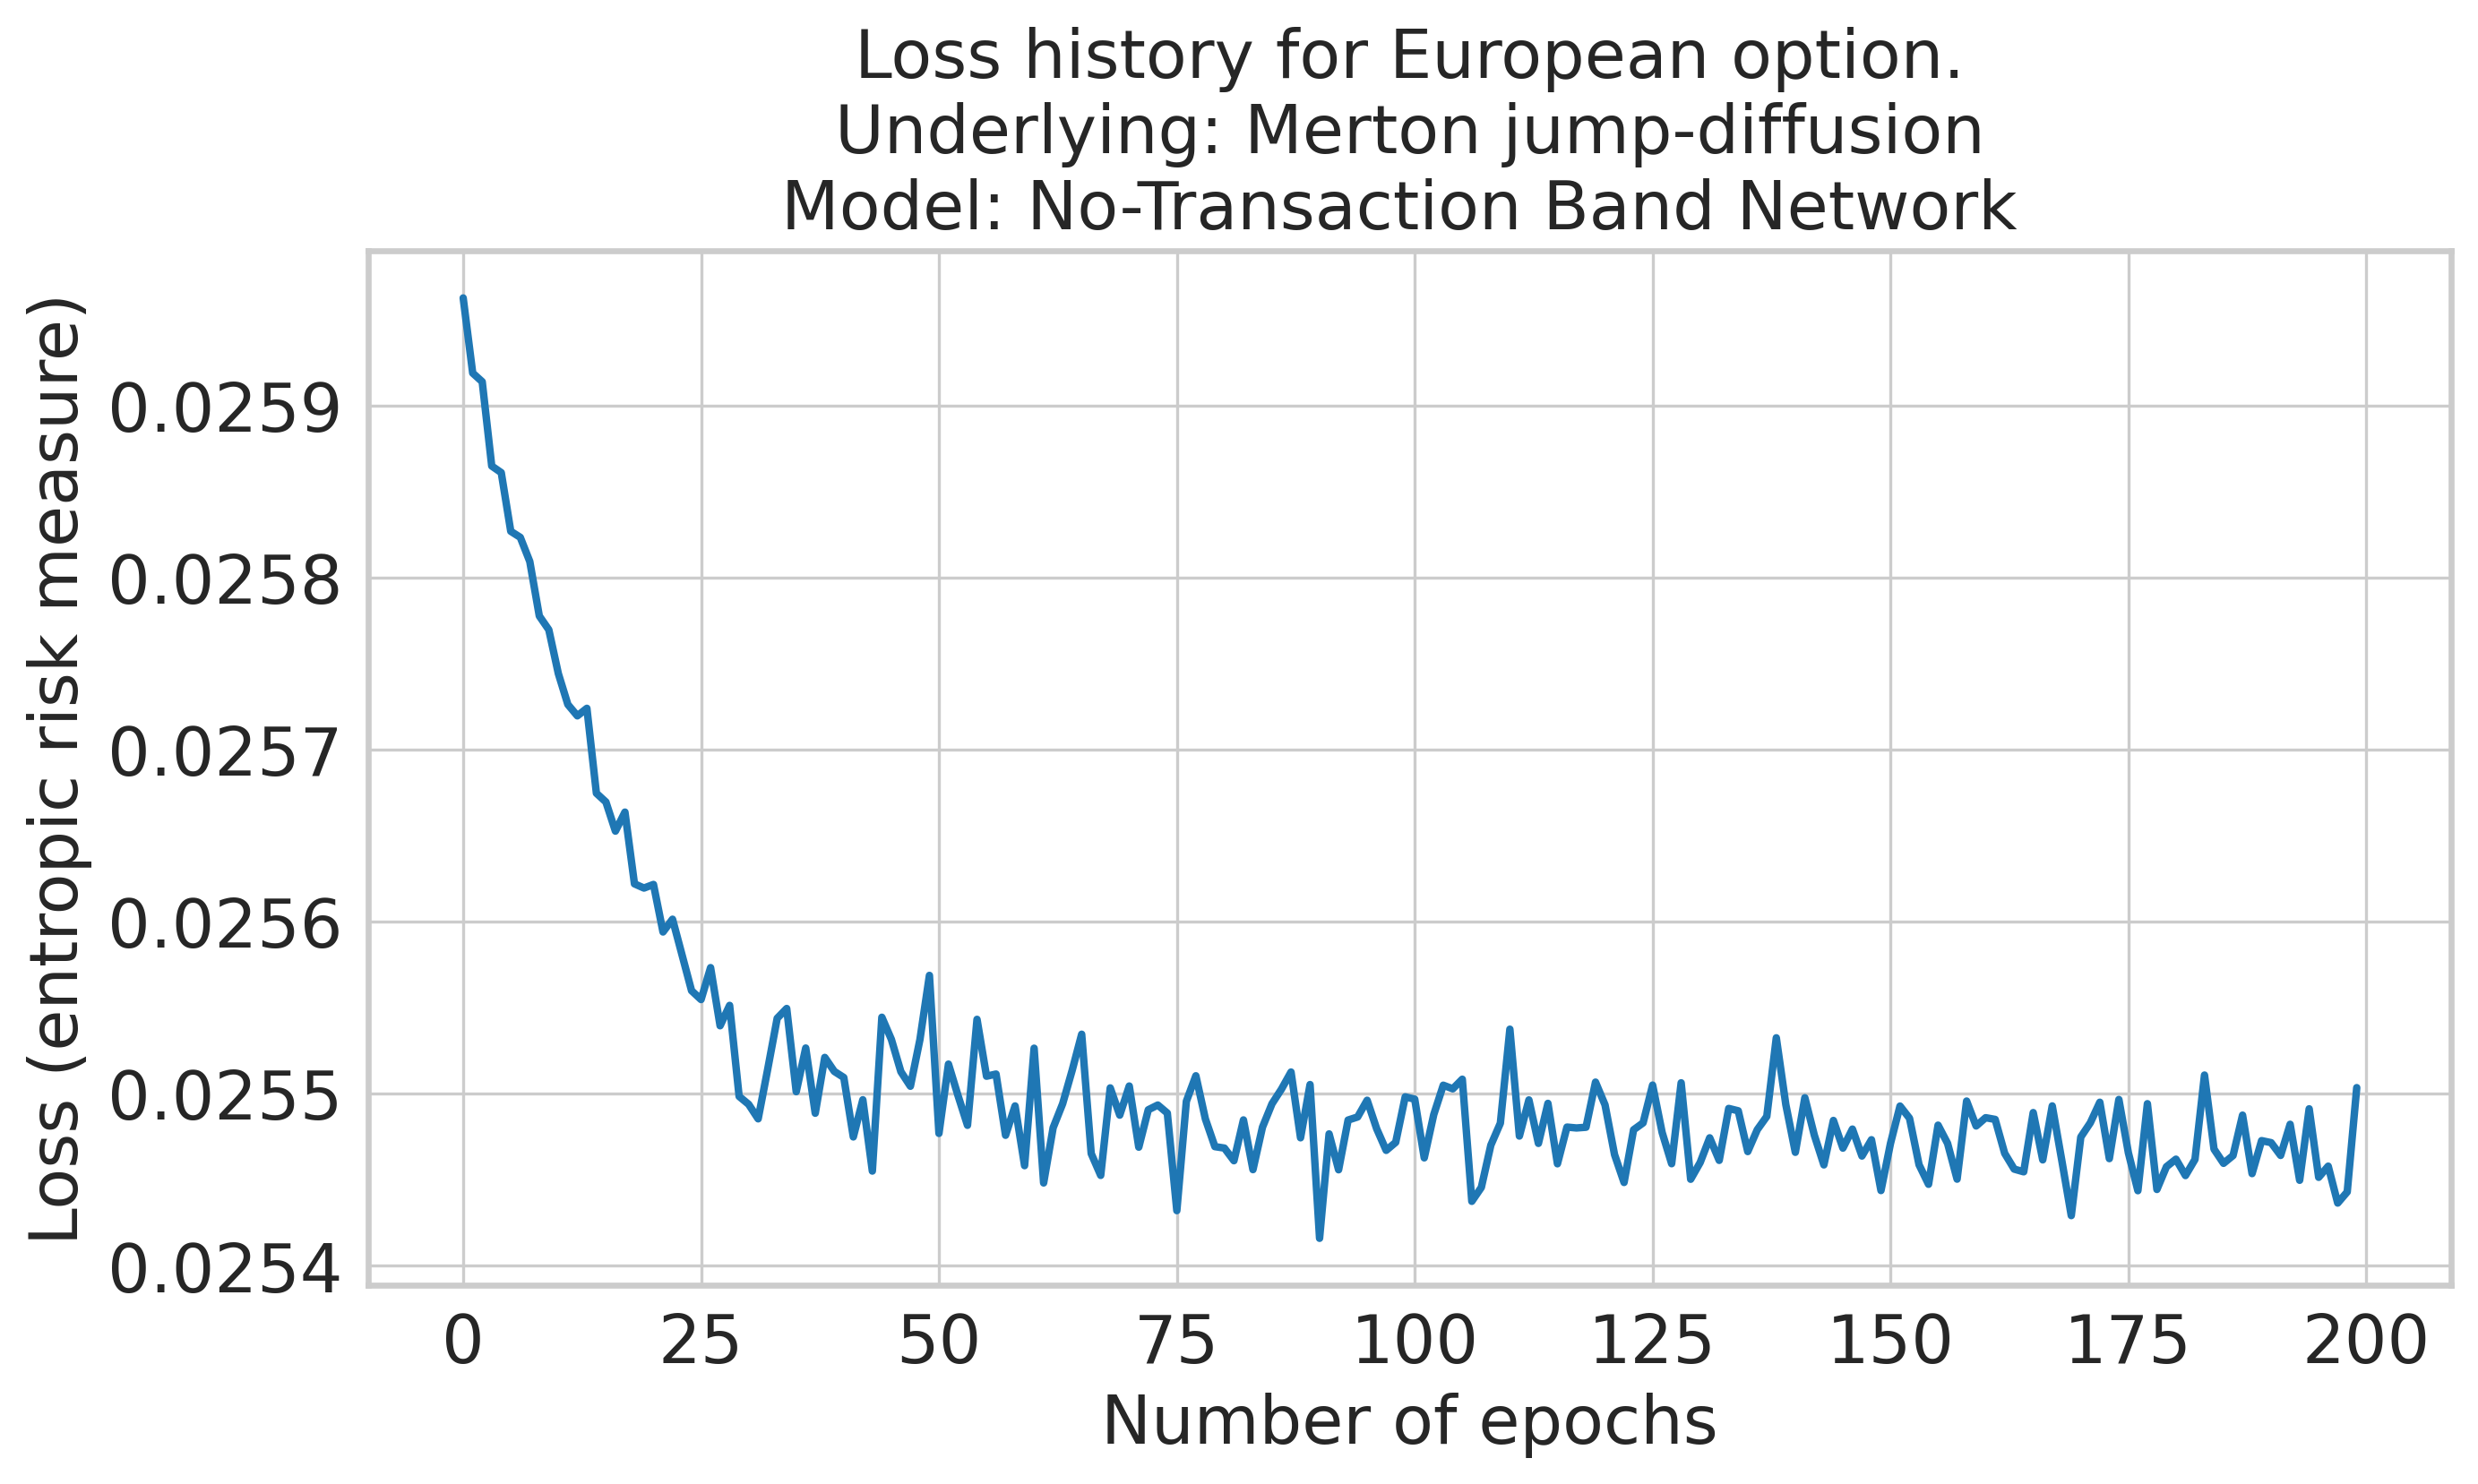

In [29]:
plot_history(history_ntband_jump, "Loss history for European option.\n"
                                  "Underlying: Merton jump-diffusion\n"
                                  "Model: No-Transaction Band Network ")

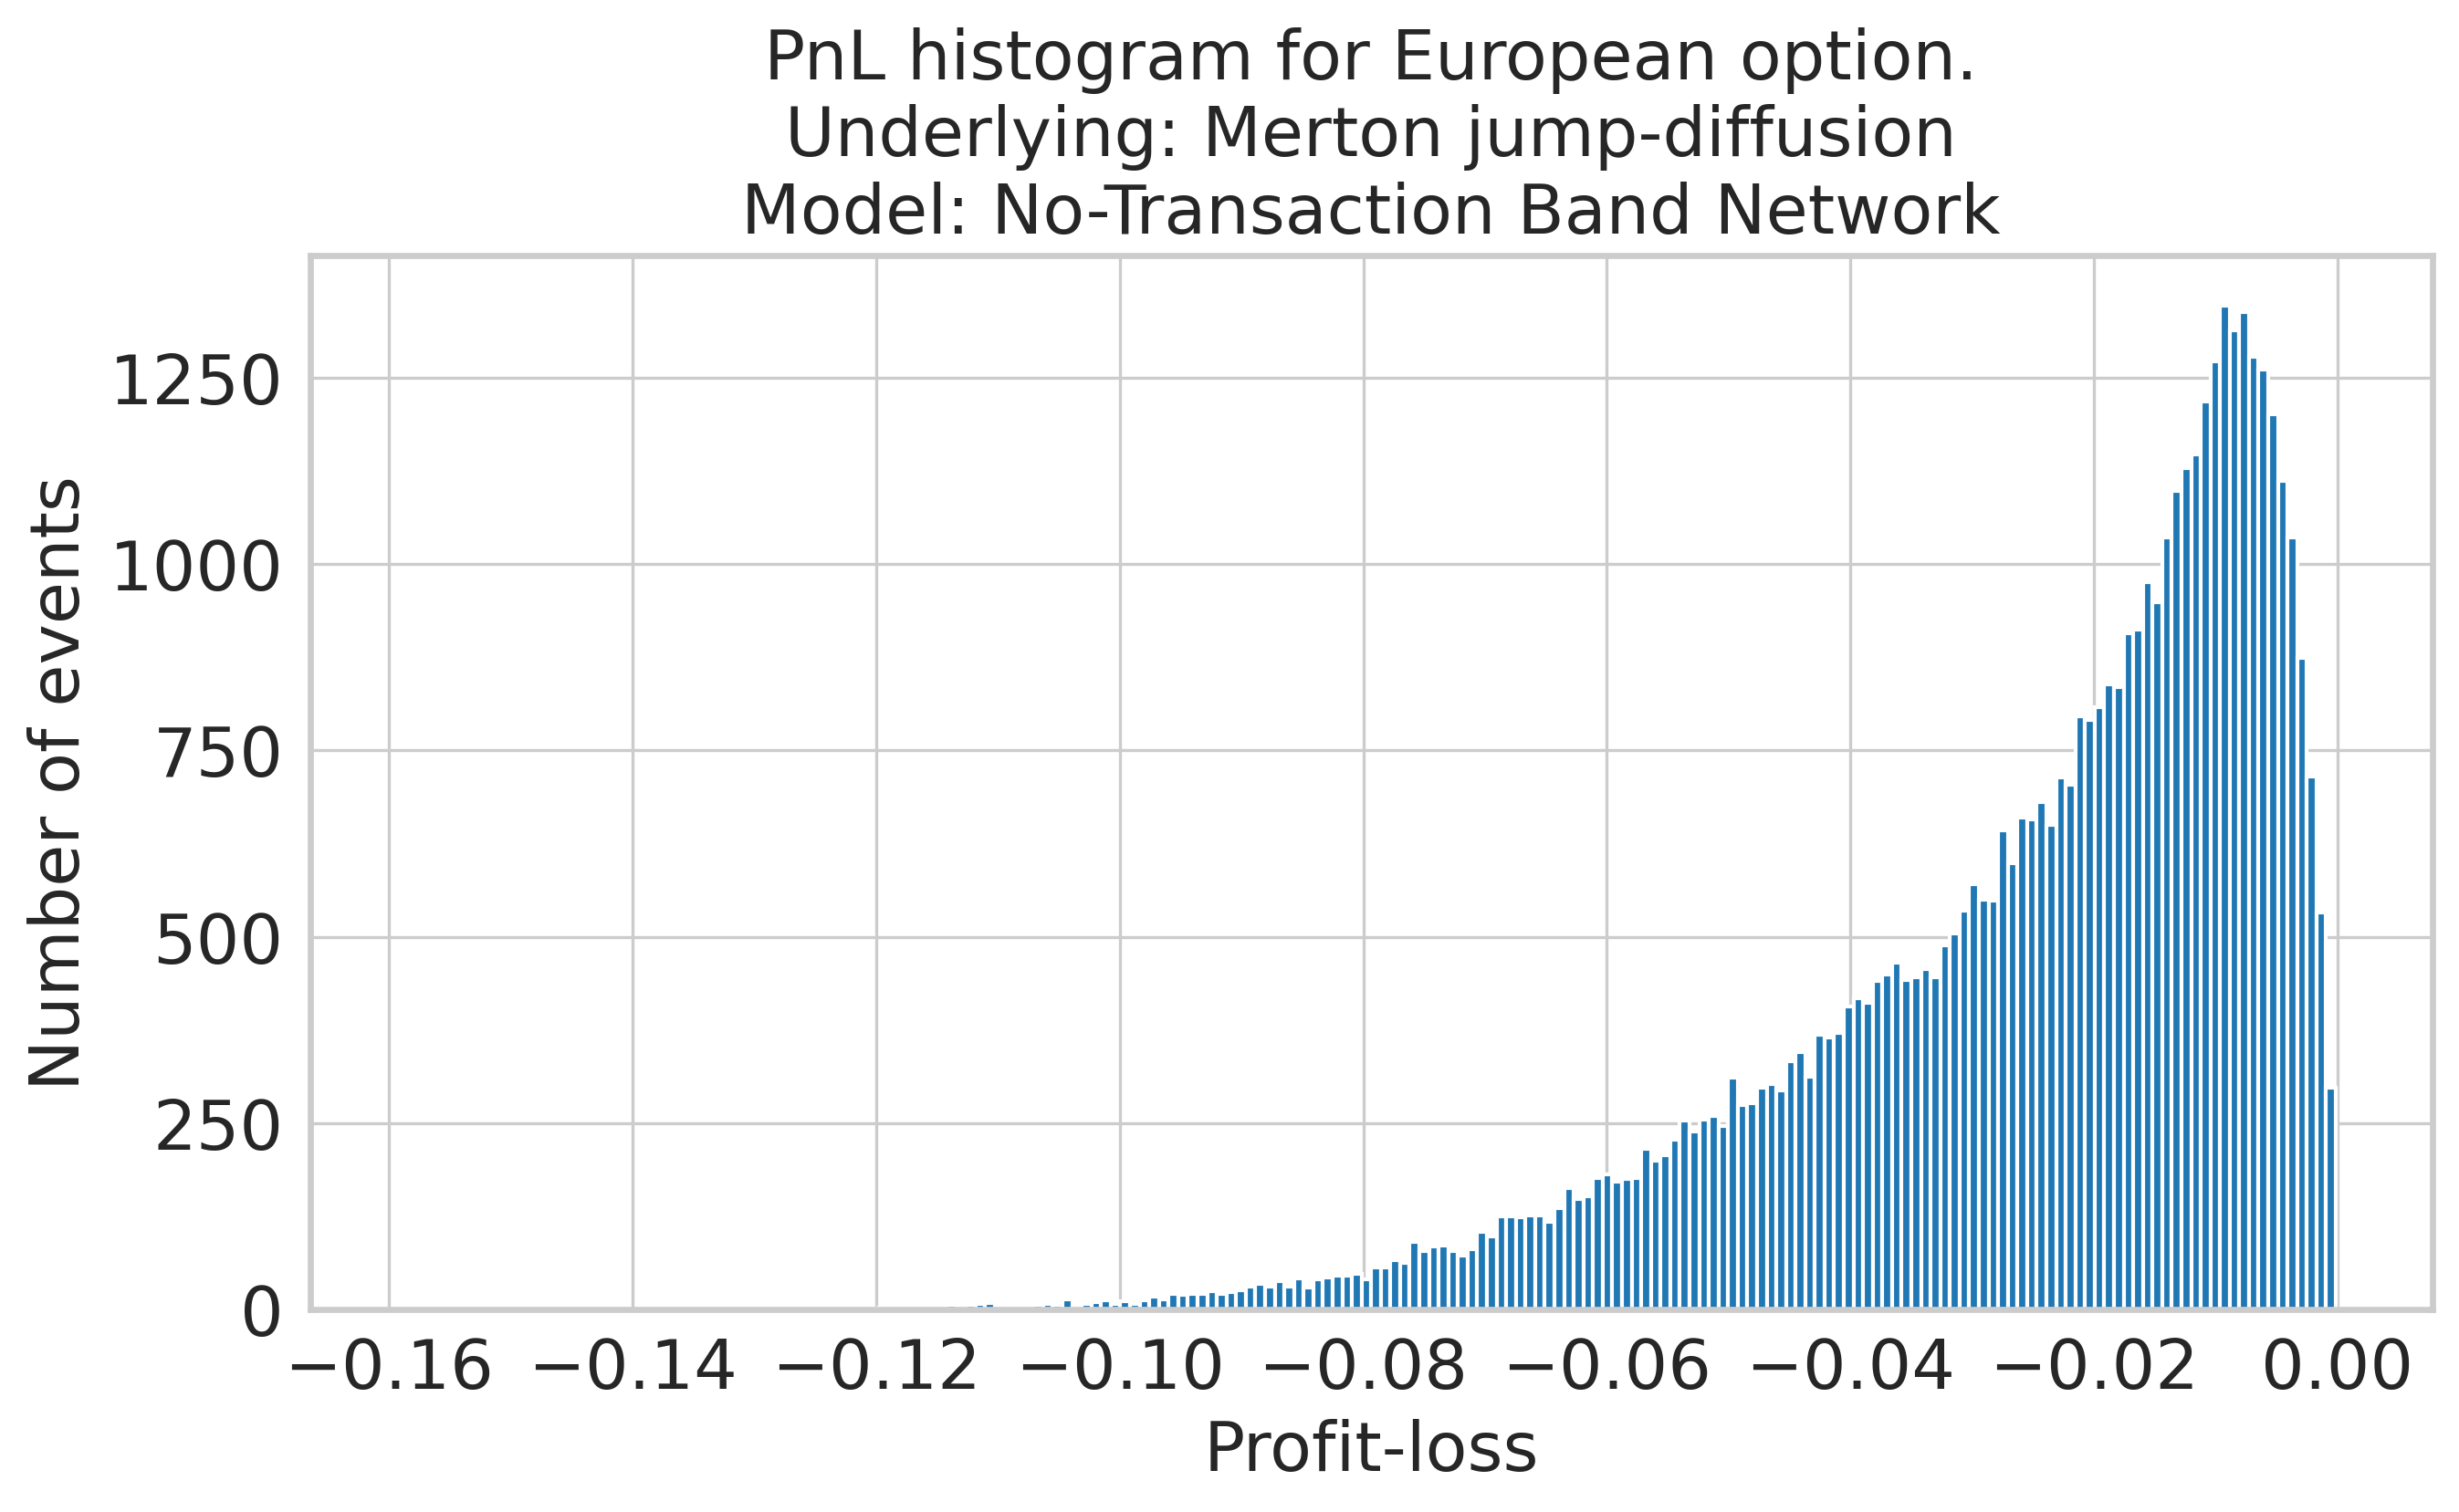

In [23]:
plot_pnl(hedger_ntband_jump, derivative_jump, n_paths=N_PATHS,
         title="PnL histogram for European option.\n"
                "Underlying: Merton jump-diffusion\n"
                "Model: No-Transaction Band Network")

In [42]:
hedger_ntband_jump.price(derivative_jump)

tensor(0.0252, device='cuda:0')

### Black-Scholes

In [24]:
model_bs_jump = BlackScholes(derivative_jump)
hedger_bs_jump = Hedger(model_bs_jump, inputs=model_bs_jump.inputs()).to(DEVICE)

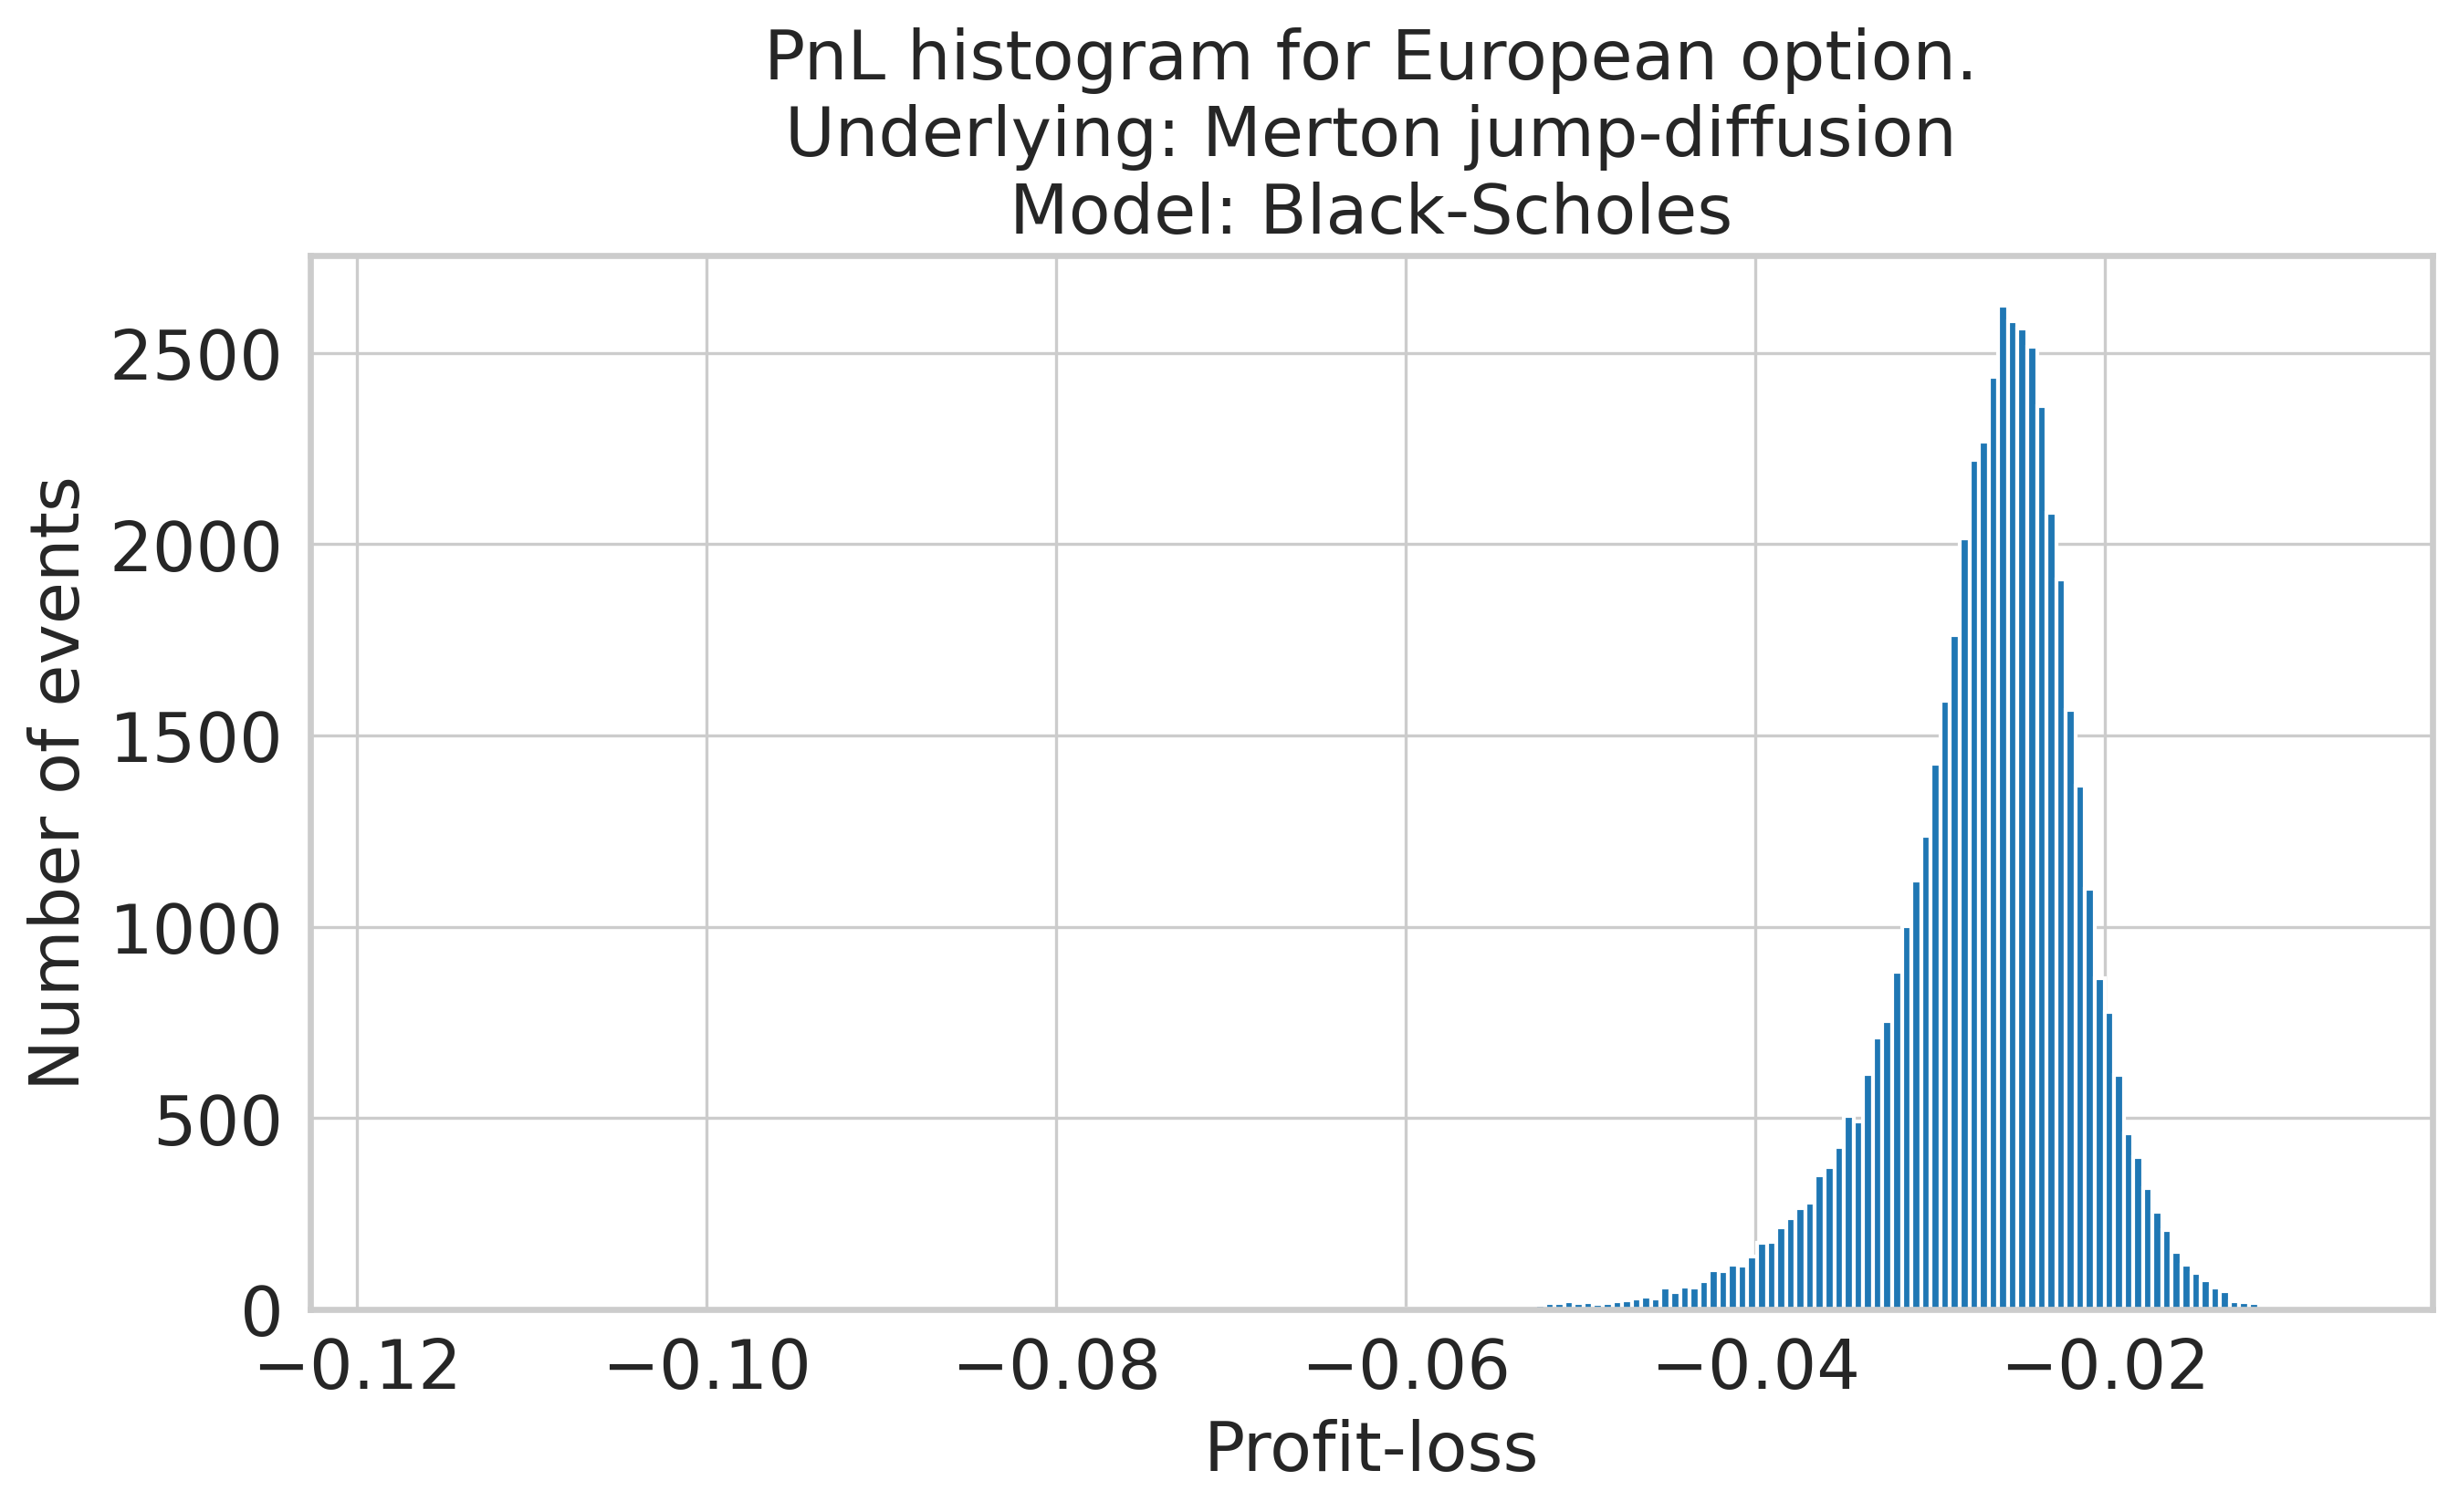

In [25]:
plot_pnl(hedger_bs_jump, derivative_jump, n_paths=N_PATHS,
         title="PnL histogram for European option.\n"
               "Underlying: Merton jump-diffusion\n"
               "Model: Black-Scholes")

In [41]:
hedger_bs_jump.price(derivative_jump)

tensor(0.0268, device='cuda:0')

# Comparison

## Brownian stock

In [ ]:
fig = go.Figure()
histnorm='probability density'
fig.add_trace(go.Histogram(x=get_pnl(hedger_mlp, derivative, N_PATHS), histnorm=histnorm,
                           name='Model: Multi-Layer Perceptron. Loss: Entropic Risk Measure'))
fig.add_trace(go.Histogram(x=get_pnl(hedger_bs, derivative, N_PATHS), histnorm=histnorm,
                           name='Model: Black-Scholes'))
fig.add_trace(go.Histogram(x=get_pnl(hedger_ww, derivative, N_PATHS), histnorm=histnorm,
                           name='Model: Whalley-Wilmott\'s Asymptotically Optimal Strategy for Small Costs'))
fig.add_trace(go.Histogram(x=get_pnl(hedger_ntband, derivative, N_PATHS), histnorm=histnorm,
                           name='Model: No-Transaction Band Network. Loss: Entropic Risk Measure'))
fig.add_trace(go.Histogram(x=get_pnl(hedger_ntband_es, derivative, N_PATHS), histnorm=histnorm,
                           name='Model: No-Transaction Band Network. Loss: Expected Shortfall'))
fig.update_layout(barmode='overlay', xaxis_title='Profit-loss', title='PnL histograms for European option')
fig.update_traces(opacity=0.85)
fig.show(renderer='browser')

## Merton jump-diffusion stock

In [40]:
fig = go.Figure()
histnorm='probability density'
fig.add_trace(go.Histogram(x=get_pnl(hedger_mlp_jump, derivative_jump, N_PATHS), histnorm=histnorm,
                           name='Model: Multi-layer perceptron. Loss: Entropic Risk Measure'))
fig.add_trace(go.Histogram(x=get_pnl(hedger_ntband_jump, derivative_jump, N_PATHS), histnorm=histnorm,
                           name='Model: No-Transaction Band Network. Loss: Entropic Risk Measure'))
fig.add_trace(go.Histogram(x=get_pnl(hedger_bs_jump, derivative_jump, N_PATHS), histnorm=histnorm,
                           name='Model: Black-Scholes. Loss: Entropic Risk Measure'))
fig.update_layout(barmode='overlay', xaxis_title='Profit-loss', title='PnL histograms for European option. Underlying: Merton jump-diffusion.')
fig.update_traces(opacity=0.85)
fig.show(renderer='browser')

Opening in existing browser session.


[10652:10685:1022/124605.517957:ERROR:bus.cc(399)] Failed to connect to the bus: Could not parse server address: Unknown address type (examples of valid types are "tcp" and on UNIX "unix")
[10652:10685:1022/124605.518211:ERROR:bus.cc(399)] Failed to connect to the bus: Could not parse server address: Unknown address type (examples of valid types are "tcp" and on UNIX "unix")
